<a href="https://colab.research.google.com/github/papagorgio23/NBA_News_Spiders/blob/master/NBA%20News%20Clustering%20Model/NBA_News_Clustering_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3 - NBA News Clustering/Topic Modeling

### Research Methods/Programming Components

This research/programming assignment involves eight activities (or ten activities with two being optional) as follows:

(1) Bring in the three matrices from the second research/programming assignment. Work with one matrix at a time in completing multivariate analysis activities below. It is convenient to have columns of matrices associated with short character strings (say, eight characters or less), so that documents may be easily identified when reviewing the results of multivariate analyses. Also, for Approaches 1 and 2, it is convenient to have rows identified by character strings for the terms. (And as stated earlier, it will be easier to complete the terms-as-objects portions of this assignment if you work with unigrams rather than bigrams, trigrams, or n-grams.)

### Understanding the Corpus: Documents as Objects

(2) Using matrices for Approaches 1, 2, and 3, perform partitioned cluster analysis (K-means) with documents as objects. Utilize objective methods for determining the number of clusters K. Prepare summary lists of documents within each cluster. If there is a large number of documents, show a sample of the documents in lists. Describe the results.

(3) Using matrices for Approaches 1, 2, and 3, perform multidimensional scaling with documents as objects. Visualize the multidimensional scaling solutions in two-space, labeling points with document names. Identify clusters from the K-means clustering with colored points, providing a legend on the visualization. Use t-distributed stochastic neighbor embedding (t-SNE) for the multidimensional scaling. If there is a large number of documents, plot a sample of the documents. Describe the results. 

(4) Compare scaling and clustering results for documents across the three approaches. What do these analyses tell you about the corpus? In your opinion, which of the three approaches provides the most clear-cut (interpretable) results?

### Understanding the Corpus: Terms as Objects


(5) Using matrices for Approaches 1 and 2, perform multidimensional scaling (t-SNE) with terms as objects. Visualize the multidimensional scaling solutions in two-space, labeling points as terms. Describe the results.

(6) Using matrices for Approaches 1 and 2, perform hierarchical cluster analysis with terms as objects. Visualize the clustering solution as a tree diagram, with terminal nodes labeled as terms. Describe the results.

(7) Compare multidimensional scaling and clustering results for terms across Approaches 1 and 2. What do these analyses tell you about the corpus? In your opinion, which of the two approaches provides the most clear-cut (interpretable) results?

(8) Using results of multidimensional scaling and clustering of terms for one of the approaches, construct an ontology or semantic network for the corpus. Use your judgment to represent this ontology as a graph with nodes for terms and links for relationships between terms. Use your favorite visualization software to draw the graph (or draw it by hand, take a photograph, and save the photo as a jpeg or png file). [Note that Protégé is a software system for constructing ontologies using RDF or OWL triples: https://protege.stanford.edu/ (Links to an external site.) ]

### Understanding the Corpus: Topic Modeling and Biclustering

(9, optional) Try a topic modeling solution such as latent Dirichlet allocation to identify documents with topics: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html (Links to an external site.)

(10, optional) To bolster interpretation of the domain of interest depicted by the corpus, employ biclustering for one of the three vectorization methods. That is, select the vectorization method that seemed to work best in previous analyses and simultaneously group documents and terms with biclustering. The biclustering may be accomplished with Scikit Learn as shown at https://scikit-learn.org/stable/modules/biclustering.html  

### Load Libraries

In [0]:
## Standard 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


## Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, string


## Prediction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

## Doc2Vec
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel




#import random
#from pprint import pprint


## Clustering
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer

## Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, ward, linkage


# spacy for lemmatization
#import spacy

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Load Articles

In [0]:
news = pd.read_csv('https://raw.githubusercontent.com/papagorgio23/NBA_News_Spiders/master/NBA_News/NBA_news_cleaned.csv')

In [0]:
news.head()

team  ...    Relevant
0  hawks  ...  Irrelevant
1  hawks  ...  Irrelevant
2  hawks  ...  Irrelevant
3  hawks  ...  Irrelevant
4  hawks  ...  Irrelevant

[5 rows x 12 columns]

In [0]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   team             768 non-null    object
 1   url              768 non-null    object
 2   date             734 non-null    object
 3   title            768 non-null    object
 4   tags             732 non-null    object
 5   article          768 non-null    object
 6   id               768 non-null    object
 7   Document_length  768 non-null    int64 
 8   article_1        751 non-null    object
 9   article_2        751 non-null    object
 10  article_3        751 non-null    object
 11  Relevant         768 non-null    object
dtypes: int64(1), object(11)
memory usage: 72.1+ KB


In [0]:
news = news.dropna(subset=['article_3'])

In [0]:
news = news.rename(columns={"article_3": "Text"})

In [0]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 751 entries, 0 to 767
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   team             751 non-null    object
 1   url              751 non-null    object
 2   date             717 non-null    object
 3   title            751 non-null    object
 4   tags             715 non-null    object
 5   article          751 non-null    object
 6   id               751 non-null    object
 7   Document_length  751 non-null    int64 
 8   article_1        751 non-null    object
 9   article_2        751 non-null    object
 10  Text             751 non-null    object
 11  Relevant         751 non-null    object
dtypes: int64(1), object(11)
memory usage: 76.3+ KB


### Global Parameters

In [0]:
### SET PARAMETERS
SET_RANDOM = 1234
MAX_NGRAM_LENGTH = 2
VECTOR_LENGTH = 300
TITLES = news['title']
DOCS = news['Text']
print("The shape of the DOCS is:", DOCS.shape)

## Adding Classification Model Flag and Document IDS
IDS = news['id']
print("The shape of the IDS is:", IDS.shape)
LABELS = news['Relevant']
print("The shape of the LABELS is:", LABELS.shape)


# reset index so they join properly
LABELS.reset_index(drop=True, inplace=True)
IDS.reset_index(drop=True, inplace=True)
DOCS.reset_index(drop=True, inplace=True)
TITLES.reset_index(drop=True, inplace=True)

The shape of the DOCS is: (751,)
The shape of the IDS is: (751,)
The shape of the LABELS is: (751,)


#### Vector Size (K) = 300

## Activity 1: Vectorizing

### Vectorization Approach

#### Approach 1: Analyst Judgment

In [0]:
##############################
### Count Vectorization
##############################

# Start Timer
start = datetime.datetime.now()

count_vectorizer = CountVectorizer(
    ngram_range = (1, MAX_NGRAM_LENGTH), 
    max_features = VECTOR_LENGTH
    )

count_vectors = count_vectorizer.fit_transform(DOCS)
print('\nAnalyst Judgment Vectorization:')
print('\nVector Shape:', count_vectors.shape)

# Convert to pandas dataframe
analyst_vec = pd.DataFrame(count_vectors.todense(), columns=count_vectorizer.get_feature_names())
analyst = pd.concat([LABELS, IDS, analyst_vec, DOCS], axis=1)


end = datetime.datetime.now()
aj1000_time_diff = end-start
print()
print('Time to Vectorize = {}'.format(aj1000_time_diff))


Analyst Judgment Vectorization:

Vector Shape: (751, 300)

Time to Vectorize = 0:00:00.803785


In [0]:
analyst.head()

Relevant  ...                                               Text
0  Irrelevant  ...   newyork feb hawk guard trae young receive jan...
1  Irrelevant  ...   world continue navigate uncertainties around ...
2  Irrelevant  ...   atlanta families senior citizens thomasville ...
3  Irrelevant  ...   espn national basketball association nba nati...
4  Irrelevant  ...   atlanta atlanta hawk hawk foundation state fa...

[5 rows x 303 columns]

In [0]:
## Save output for reproducibility 
analyst.to_csv("Analyst.csv", index=False)

In [0]:
analyst.describe()

able         add       allow  ...       years       young       youre
count  751.000000  751.000000  751.000000  ...  751.000000  751.000000  751.000000
mean     0.316911    0.271638    0.187750  ...    0.470040    0.331558    0.223702
std      0.960955    0.633073    0.589381  ...    1.064002    1.190206    0.831399
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
75%      0.000000    0.000000    0.000000  ...    1.000000    0.000000    0.000000
max     11.000000    5.000000    5.000000  ...    9.000000   15.000000   10.000000

[8 rows x 300 columns]

#### Approach 2: TF-IDF

In [0]:
##############################
### TF-IDF Vectorization
##############################
# Start Timer
start = datetime.datetime.now()

# initalize TF-IDF
tfidf_vectorizer = TfidfVectorizer(encoding='utf-8',
                        ngram_range = (1, MAX_NGRAM_LENGTH), 
                        stop_words=None,
                        lowercase=False,
                        max_df=0.95,
                        min_df=10,
                        max_features=VECTOR_LENGTH,
                        norm='l2',
                        sublinear_tf=True)

# transform data
tfidf_vectors = tfidf_vectorizer.fit_transform(DOCS)
print('\nTF-IDF Vectorization:')
print('\nVector Shape:', tfidf_vectors.shape)

# Convert to pandas dataframe
TF_df = pd.DataFrame(tfidf_vectors.todense(), columns=tfidf_vectorizer.get_feature_names())

# put in dataframe
TFIDF = pd.concat([LABELS, IDS, TF_df, DOCS], axis=1)


end = datetime.datetime.now()
tf1000_time_diff = end-start
print()
print('Time to train = {}'.format(tf1000_time_diff))


TF-IDF Vectorization:

Vector Shape: (751, 300)

Time to train = 0:00:00.791157


In [0]:
TFIDF.head()

Relevant  ...                                               Text
0  Irrelevant  ...   newyork feb hawk guard trae young receive jan...
1  Irrelevant  ...   world continue navigate uncertainties around ...
2  Irrelevant  ...   atlanta families senior citizens thomasville ...
3  Irrelevant  ...   espn national basketball association nba nati...
4  Irrelevant  ...   atlanta atlanta hawk hawk foundation state fa...

[5 rows x 303 columns]

In [0]:
## Save output for reproducibility 
TFIDF.to_csv("TFIDF.csv", index=False)

In [0]:
TFIDF.describe()

able         add       allow  ...       years       young       youre
count  751.000000  751.000000  751.000000  ...  751.000000  751.000000  751.000000
mean     0.018029    0.019038    0.014560  ...    0.024860    0.020584    0.013685
std      0.042987    0.042336    0.044702  ...    0.045802    0.056742    0.041867
min      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
25%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
50%      0.000000    0.000000    0.000000  ...    0.000000    0.000000    0.000000
75%      0.000000    0.000000    0.000000  ...    0.048351    0.000000    0.000000
max      0.289932    0.230287    0.433482  ...    0.223946    0.546386    0.341953

[8 rows x 300 columns]

#### Approach 3: Doc2Vec

##### Additional Data Prep

In [0]:
DOCS_list = DOCS.str.strip().values.tolist()

In [0]:
# text parsing function for entire document string
def parse_doc(text):
    codelist = ['\r', '\n', '\t'] 
    text = text.lower()
    text = re.sub(r'&(.)+', "", text)  # no & references  
    text = re.sub(r'pct', 'percent', text)  # replace pct abreviation  
    text = re.sub(r"[^\w\d'\s]+", '', text)  # no punct except single quote 
    text = re.sub(r'[^\x00-\x7f]',r'', text)  # no non-ASCII strings    
    if text.isdigit(): text = ""  # omit words that are all digits    
    for code in codelist:
        text = re.sub(code, ' ', text)  # get rid of escape codes  
    # replace multiple spaces with one space
    text = re.sub('\s+', ' ', text)        
    return text

In [0]:
# text parsing for words within entire document string
# splits the document string into words/tokens
# parses the words and then recreates a document string
# returns list of parsed words/tokens and parsed document string
def parse_words(text): 
    # split document into individual words
    tokens=text.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out tokens that are one or two characters long
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens that are more than twenty characters long
    tokens = [word for word in tokens if len(word) < 21]
    # recreate the document string from parsed words
    text = ''
    for token in tokens:
        text = text + ' ' + token
    return tokens, text 

In [0]:

##############################
### Prepare Training Data 
##############################
tokens = []  # list of token lists for gensim Doc2Vec
text = [] # list of document strings for sklearn TF-IDF
labels = []  # use filenames as labels
for doc in DOCS_list:
    text_string = doc
    # parse the entire document string
    text_string = parse_doc(text_string)
    # parse words one at a time in document string
    doc_tokens, text_string = parse_words(text_string)
    tokens.append(doc_tokens)
    text.append(text_string)
print('\nNumber of training documents:',
	len(text))	
print('\nFirst item after text preprocessing, train_text[0]\n', 
	text[0])
print('\nNumber of training token lists:',
	len(tokens))	
print('\nFirst list of tokens after text preprocessing, train_tokens[0]\n', 
	tokens[0])


Number of training documents: 751

First item after text preprocessing, train_text[0]
  newyork feb hawk guard trae young receive january nba care community assist award present kaiser permanente recognition efforts impact live youth families need georgia oklahoma nba announce todaythe award recognize player month best reflect passion league nba players share give back communities tip young help alleviate financial hardship atlanta families partner rip medical debt relieve insurmountable health expense young donate trae young foundation help eliminate million medical debt nearly individuals throughout atlanta additionally young provide youth native oklahoma place develop skills learn value game trae young basketball academy also help promote education inclusion health wellness across atlanta trae young foundation establish focus generate awareness mental health cyber social media bully foundation aim positively impact children adults face mental health challenge education research you

##### Train Doc2Vec

In [0]:
###########################################
### Doc2Vec Vectorization (1000 dimensions)
###########################################

# Start Timer
start = datetime.datetime.now()


print('\nBegin Doc2Vec Work')
cores = multiprocessing.cpu_count()
print("\nNumber of processor cores:", cores)

corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokens)]

# Instantiate a Doc2Vec model with a vector size with 300 words 
print("\nWorking on Doc2Vec vectorization, dimension 300")
doc2vec_300 = Doc2Vec(corpus, vector_size = VECTOR_LENGTH, window = 4, 
	min_count = 2, workers = cores, epochs = 100)

# build vectorization model on training set
doc2vec_300.train(corpus, total_examples = doc2vec_300.corpus_count, 
	epochs = doc2vec_300.epochs)  


# vectorization for the training set
doc2vec_300_vectors = np.zeros((len(tokens), 300)) # initialize numpy array
for i in range(0, len(tokens)):
    doc2vec_300_vectors[i,] = doc2vec_300.infer_vector(tokens[i]).transpose()
print('\nDoc2Vec Shape:', doc2vec_300_vectors.shape)


# Convert to pandas dataframe
NN_DF = pd.DataFrame(doc2vec_300_vectors)

# put in dataframe
NN_DF = pd.concat([LABELS, IDS, NN_DF, DOCS], axis=1)


end = datetime.datetime.now()
doc300_time_diff = end-start
print()
print()
print('Time to train = {}'.format(doc300_time_diff))


Begin Doc2Vec Work

Number of processor cores: 2

Working on Doc2Vec vectorization, dimension 300

Doc2Vec Shape: (751, 300)


Time to train = 0:02:24.878885


In [0]:
NN_DF.head()

Relevant  ...                                               Text
0  Irrelevant  ...   newyork feb hawk guard trae young receive jan...
1  Irrelevant  ...   world continue navigate uncertainties around ...
2  Irrelevant  ...   atlanta families senior citizens thomasville ...
3  Irrelevant  ...   espn national basketball association nba nati...
4  Irrelevant  ...   atlanta atlanta hawk hawk foundation state fa...

[5 rows x 303 columns]

In [0]:
## Save output for reproducibility 
NN_DF.to_csv("NN_DF.csv", index=False)

# Understanding the Corpus: Documents as Objects

## Activity 2: K-Means Clustering

### Global Parameters

In [0]:
CLUSTERS = 6

### Approach 1: Analyst Judgment

#### Train Model

In [0]:
# Start Timer
start = datetime.datetime.now()

# initialize model
KM_Analyst = KMeans(n_clusters = CLUSTERS, 
                    random_state = SET_RANDOM)

# Train Model
KM_Analyst.fit(analyst_vec)
KM_Analyst_clusters = KM_Analyst.labels_.tolist()

# Stop Timer
end = datetime.datetime.now()
aclust_time_diff = end-start
print()
print('Time to Cluster = {}'.format(aclust_time_diff))


Time to Cluster = 0:00:00.242573


In [0]:
# put in dataframe
Analyst_Cluster = pd.DataFrame({'Cluster':KM_Analyst_clusters})

Analyst_Cluster = pd.concat([Analyst_Cluster, LABELS, IDS, TITLES, DOCS], axis=1)
Analyst_Cluster['record'] = 1
Analyst_Cluster.head()

Cluster  ... record
0        1  ...      1
1        1  ...      1
2        1  ...      1
3        1  ...      1
4        1  ...      1

[5 rows x 6 columns]

In [0]:
# Get Terms 
analyst_terms = count_vectorizer.get_feature_names()

# Group by Clusters
Analyst_pivot = pd.pivot_table(Analyst_Cluster, values='record', index='Relevant',
                               columns='Cluster', aggfunc=np.sum)

#### Cluster Results

In [0]:
# Show how the topics relate to our Classification Model
Analyst_pivot

Cluster         0      1    2     3    4     5
Relevant                                      
Irrelevant  118.0  315.0  1.0  32.0  1.0   9.0
Relevant    117.0  118.0  NaN   5.0  NaN  35.0

In [0]:
## Give Key Terms and Titles for each Cluster
print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = KM_Analyst.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(CLUSTERS):
    print("\nCluster %d - Key Terms:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % analyst_terms[ind])
        terms_dict.append(analyst_terms[ind])
        temp_terms.append(analyst_terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d Titles:" % i, end='')
    temp=Analyst_Cluster[Analyst_Cluster['Cluster']==i]
    for title in temp['title']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
        print()
    cluster_title[i]=temp_titles

Top terms per cluster:

Cluster 0 - Key Terms:
 game
 point
 season
 play
 team
 get
 nba
 say
 first
 make
 one
 win
 time
 go
 shoot
Cluster 0 Titles: Lloyd Pierce Hosts First-Annual Spades Tournament | Atlanta Hawks,
 Atlanta Hawks Sign Brandon Goodwin to Multi-Year Contract | Atlanta Hawks,
 Hawks Acquire Dewayne Dedmon, Draft Picks From Kings in Exchange For Alex Len and Jabari Parker | Atlanta Hawks,
 Trae Young Selected To Participate In 2020 NBA Rising Stars | Atlanta Hawks,
 Hawks Learn About Atlanta's History and Cultural Impact from "Day in the A" | Atlanta Hawks,
 Trae Young Selected To Participate In All-Star 3-Point Contest | Atlanta Hawks,
 Trae Young Still Leads Eastern Conference Guards in Third Fan Returns of NBA All-Star Voting | Atlanta Hawks,
 Hawks Players, Coaches, Ownership Mourn Passing Of Kobe Bryant | Atlanta Hawks,
 6 Reasons Why Trae Young Deserves To Be An All-Star | Atlanta Hawks,
 Short-Handed Hawks Grab Impressive Win Over Clippers | Atlanta Hawks,
 Haw

### Approach 2: TF-IDF

#### Train Model

In [0]:
# Start Timer
start = datetime.datetime.now()

# initialize model
KM_TFIDF = KMeans(n_clusters = CLUSTERS, 
                  random_state = SET_RANDOM)

# Train Model
KM_TFIDF.fit(tfidf_vectors)
KM_TFIDF_clusters = KM_TFIDF.labels_.tolist()

# Stop Timer
end = datetime.datetime.now()
tfclust_time_diff = end-start
print()
print('Time to Cluster = {}'.format(tfclust_time_diff))


Time to Cluster = 0:00:06.295365


In [0]:
# put in dataframe
TFIDF_Cluster = pd.DataFrame({'Cluster':KM_TFIDF_clusters})

TFIDF_Cluster = pd.concat([TFIDF_Cluster, LABELS, IDS, TITLES, DOCS], axis=1)
TFIDF_Cluster['record'] = 1
TFIDF_Cluster.head()

Cluster  ... record
0        0  ...      1
1        5  ...      1
2        5  ...      1
3        0  ...      1
4        5  ...      1

[5 rows x 6 columns]

In [0]:
# Get Terms 
TFIDF_terms = tfidf_vectorizer.get_feature_names()

# Group by Clusters
TFIDF_pivot = pd.pivot_table(TFIDF_Cluster, values='record', index='Relevant',
                             columns='Cluster', aggfunc=np.sum)

#### Cluster Results

In [0]:
# Show how the topics relate to our Classification Model
TFIDF_pivot

Cluster       0   1    2   3    4   5
Relevant                             
Irrelevant  172  16   77  70  111  30
Relevant     16  66  120  15   32  26

In [0]:
## Give Key Terms and Titles for each Cluster
print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = KM_TFIDF.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(CLUSTERS):
    print("\nCluster %d - Key Terms:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % TFIDF_terms[ind])
        terms_dict.append(TFIDF_terms[ind])
        temp_terms.append(TFIDF_terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d Titles:" % i, end='')
    temp=TFIDF_Cluster[TFIDF_Cluster['Cluster']==i]
    for title in temp['title']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
        print()
    cluster_title[i]=temp_titles

Top terms per cluster:

Cluster 0 - Key Terms:
 community
 support
 kings
 fan
 provide
 health
 nba
 game
 work
 help
 team
 sport
 sacramento
 partner
 continue
Cluster 0 Titles: Trae Young Receives January NBA Cares Community Assist Award Presented By Kaiser Permanente | Atlanta Hawks,
 NBA All-Stars Chris Paul and Trae Young and 2020 Hall of Fame Inductee Tamika Catchings Headline First-Ever NBA HORSE Challenge Presented by State Farm ® | Atlanta Hawks,
 Hawks Receive Two Awards At 2020 NBA Sales & Marketing Meeting | Atlanta Hawks,
 Hawks President, GM Travis Schlenk, John Collins Issue Statements Regarding Suspension | Atlanta Hawks,
 Atlanta Hawks Announce 2019 Training Camp Roster | Atlanta Hawks,
 Celtics and Vistaprint Launch 'Food For Heroes' Campaign | Boston Celtics,
 Statement On Season Suspension | Boston Celtics,
 Statement on Postponement of Celtics Games | Boston Celtics,
 NBA to suspend season following Wednesday's games | NBA.com,
 Statement From The Boston Celtics 

### Approach 3: Doc2Vec

#### Train Model

In [0]:
# Start Timer
start = datetime.datetime.now()

# initialize model
KM_DOC = KMeans(n_clusters = CLUSTERS, 
                random_state = SET_RANDOM)

# Train Model
KM_DOC.fit(doc2vec_300_vectors)
KM_DOC_clusters = KM_DOC.labels_.tolist()

# Stop Timer
end = datetime.datetime.now()
dclust_time_diff = end-start
print()
print('Time to Cluster = {}'.format(dclust_time_diff))


Time to Cluster = 0:00:00.237914


In [0]:
# put in dataframe
DOC_Cluster = pd.DataFrame({'Cluster':KM_DOC_clusters})

DOC_Cluster = pd.concat([DOC_Cluster, LABELS, IDS, TITLES, DOCS], axis=1)
DOC_Cluster['record'] = 1
DOC_Cluster.head()

Cluster  ... record
0        5  ...      1
1        5  ...      1
2        5  ...      1
3        5  ...      1
4        5  ...      1

[5 rows x 6 columns]

In [0]:
# Group by Clusters
DOC_pivot = pd.pivot_table(DOC_Cluster, values='record', index='Relevant',
                           columns='Cluster', aggfunc=np.sum)

#### Cluster Results

In [0]:
# Show how the topics relate to our Classification Model
DOC_pivot

Cluster       0      1     2    3     4      5
Relevant                                      
Irrelevant  5.0   38.0  34.0  6.0  85.0  308.0
Relevant    4.0  153.0   NaN  NaN  11.0  107.0

In [0]:
## Give Key Terms and Titles for each Cluster
print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = KM_DOC.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]

#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

# dictionary to store terms and titles
cluster_terms={}
cluster_title={}

for i in range(CLUSTERS):
    print("\nCluster %d - Key Terms:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :15]:
        print(' %s' % ind)
        terms_dict.append(ind)
        temp_terms.append(ind)
    cluster_terms[i]=temp_terms
    
    print("Cluster %d Titles:" % i, end='')
    temp=DOC_Cluster[DOC_Cluster['Cluster']==i]
    for title in temp['title']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
        print()
    cluster_title[i]=temp_titles

Top terms per cluster:

Cluster 0 - Key Terms:
 152
 241
 201
 119
 121
 169
 254
 12
 269
 143
 291
 19
 158
 225
 175
Cluster 0 Titles: Preview: Denver Nuggets back in action in 2K battle against Los Angeles Lakers | Denver Nuggets,
 NBA 2K Game Recap: Denver Nuggets 79, Los Angeles Lakers 72 | Denver Nuggets,
 Vlatko Čančar's Denver Nuggets Blog: Dealing with player trades and my favorite moment in the NBA | Denver Nuggets,
 Denver Nuggets Roundtable: How player development has helped build a contender | Denver Nuggets,
 Heads Up | Oklahoma City Thunder,
 Story Behind the Shot | Staying Locked In | Philadelphia 76ers,
 Coat Check | 3.6.20 | Philadelphia 76ers,
 Coat Check | 2.29.20 | Philadelphia 76ers,
 Ariza, Swanigan And Gabriel Arrive After Trade With Kings | Portland Trail Blazers,

Cluster 1 - Key Terms:
 57
 12
 254
 169
 161
 273
 19
 3
 119
 163
 120
 113
 240
 44
 291
Cluster 1 Titles: How Trae Young's All-Star Debut Was One For The Books | Atlanta Hawks,
 6 Reasons Why Tr

## Activity 3: Multidimensional Scaling

### Approach 1: Analyst Judgment

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

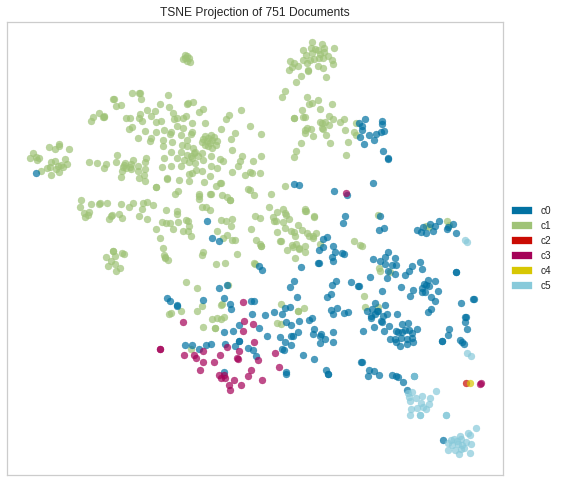

In [0]:
# Apply clustering to visualize
tsne = TSNEVisualizer(size = (800, 600))
tsne.make_transformer()
tsne.fit(analyst_vec, ["c{}".format(c) for c in KM_Analyst.labels_])
tsne.poof()

### Approach 2: TF-IDF

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

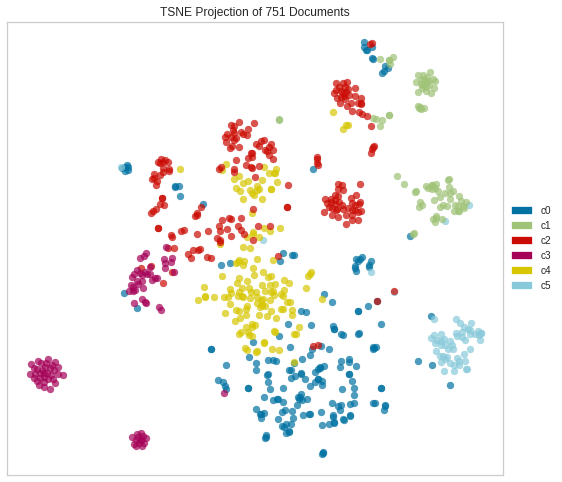

In [0]:
# Apply clustering to visualize
tsne = TSNEVisualizer(size = (800, 600))
tsne.make_transformer()
tsne.fit(tfidf_vectors, ["c{}".format(c) for c in KM_TFIDF.labels_])
tsne.poof()

### Approach 3: Doc2Vec

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

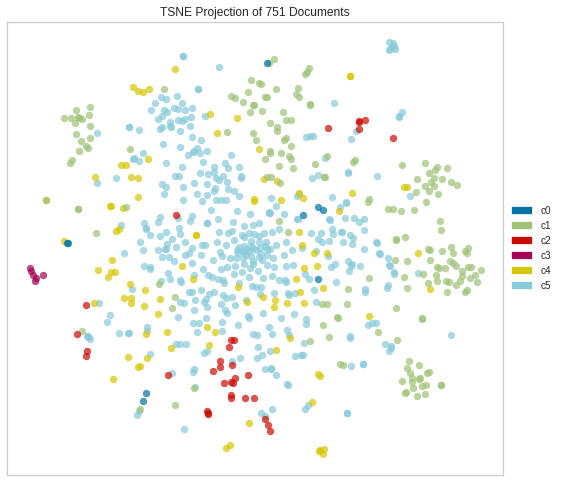

In [0]:
# Apply clustering to visualize
tsne = TSNEVisualizer(size = (800, 600))
tsne.make_transformer()
tsne.fit(doc2vec_300_vectors, ["c{}".format(c) for c in KM_DOC.labels_])
tsne.poof()

## Activity 4: Compare Clustering and Multidimensional Scaling


# Understanding the Corpus: Terms as Objects

## Activity 5: t-SNE

### Approach 1: Analyst Judgment

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

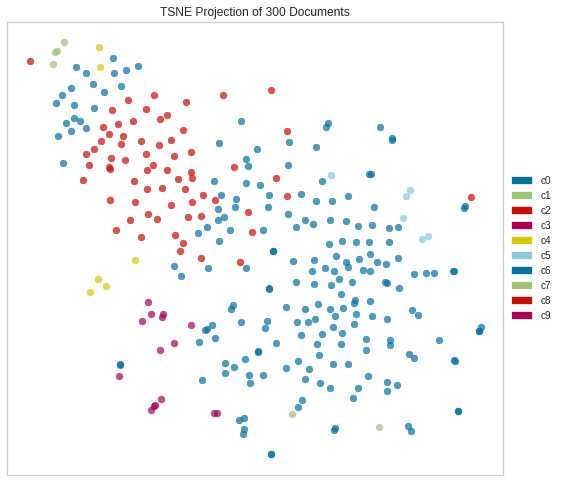


Time to Cluster = 0:00:02.397211


In [0]:
# Start Timer
start = datetime.datetime.now()

# initialize model
WKM_Analyst = KMeans(n_clusters = 10, 
                    random_state = SET_RANDOM)

# Train Model
WKM_Analyst.fit(analyst_vec.T)
WKM_Analyst_clusters = WKM_Analyst.labels_.tolist()

# Apply clustering to visualize
tsne = TSNEVisualizer(size = (800, 600))
tsne.make_transformer()
tsne.fit(analyst_vec.T, ["c{}".format(c) for c in WKM_Analyst.labels_])
tsne.poof()

# Stop Timer
end = datetime.datetime.now()
aclust_time_diff = end-start
print()
print('Time to Cluster = {}'.format(aclust_time_diff))

### Approach 2: TF-IDF

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

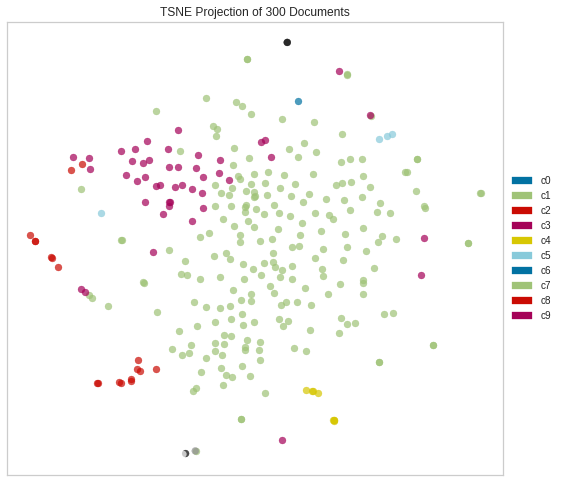


Time to Cluster = 0:00:07.066925


In [0]:
# Start Timer
start = datetime.datetime.now()

# initialize model
WKM_TFIDF = KMeans(n_clusters = 10, 
                  random_state = SET_RANDOM)

# Train Model
WKM_TFIDF.fit(tfidf_vectors.T)
WKM_TFIDF_clusters = WKM_TFIDF.labels_.tolist()

# Apply clustering to visualize
tsne = TSNEVisualizer(size = (800, 600))
tsne.make_transformer()
tsne.fit(tfidf_vectors.T, ["c{}".format(c) for c in WKM_TFIDF.labels_])
tsne.poof()

# Stop Timer
end = datetime.datetime.now()
tfclust_time_diff = end-start
print()
print('Time to Cluster = {}'.format(tfclust_time_diff))

## Activity 6: Hierarchical Clustering


### Approach 1: Analyst Judgment

In [0]:
# prepare Dendrogram data
analyst_trans = analyst_vec.T

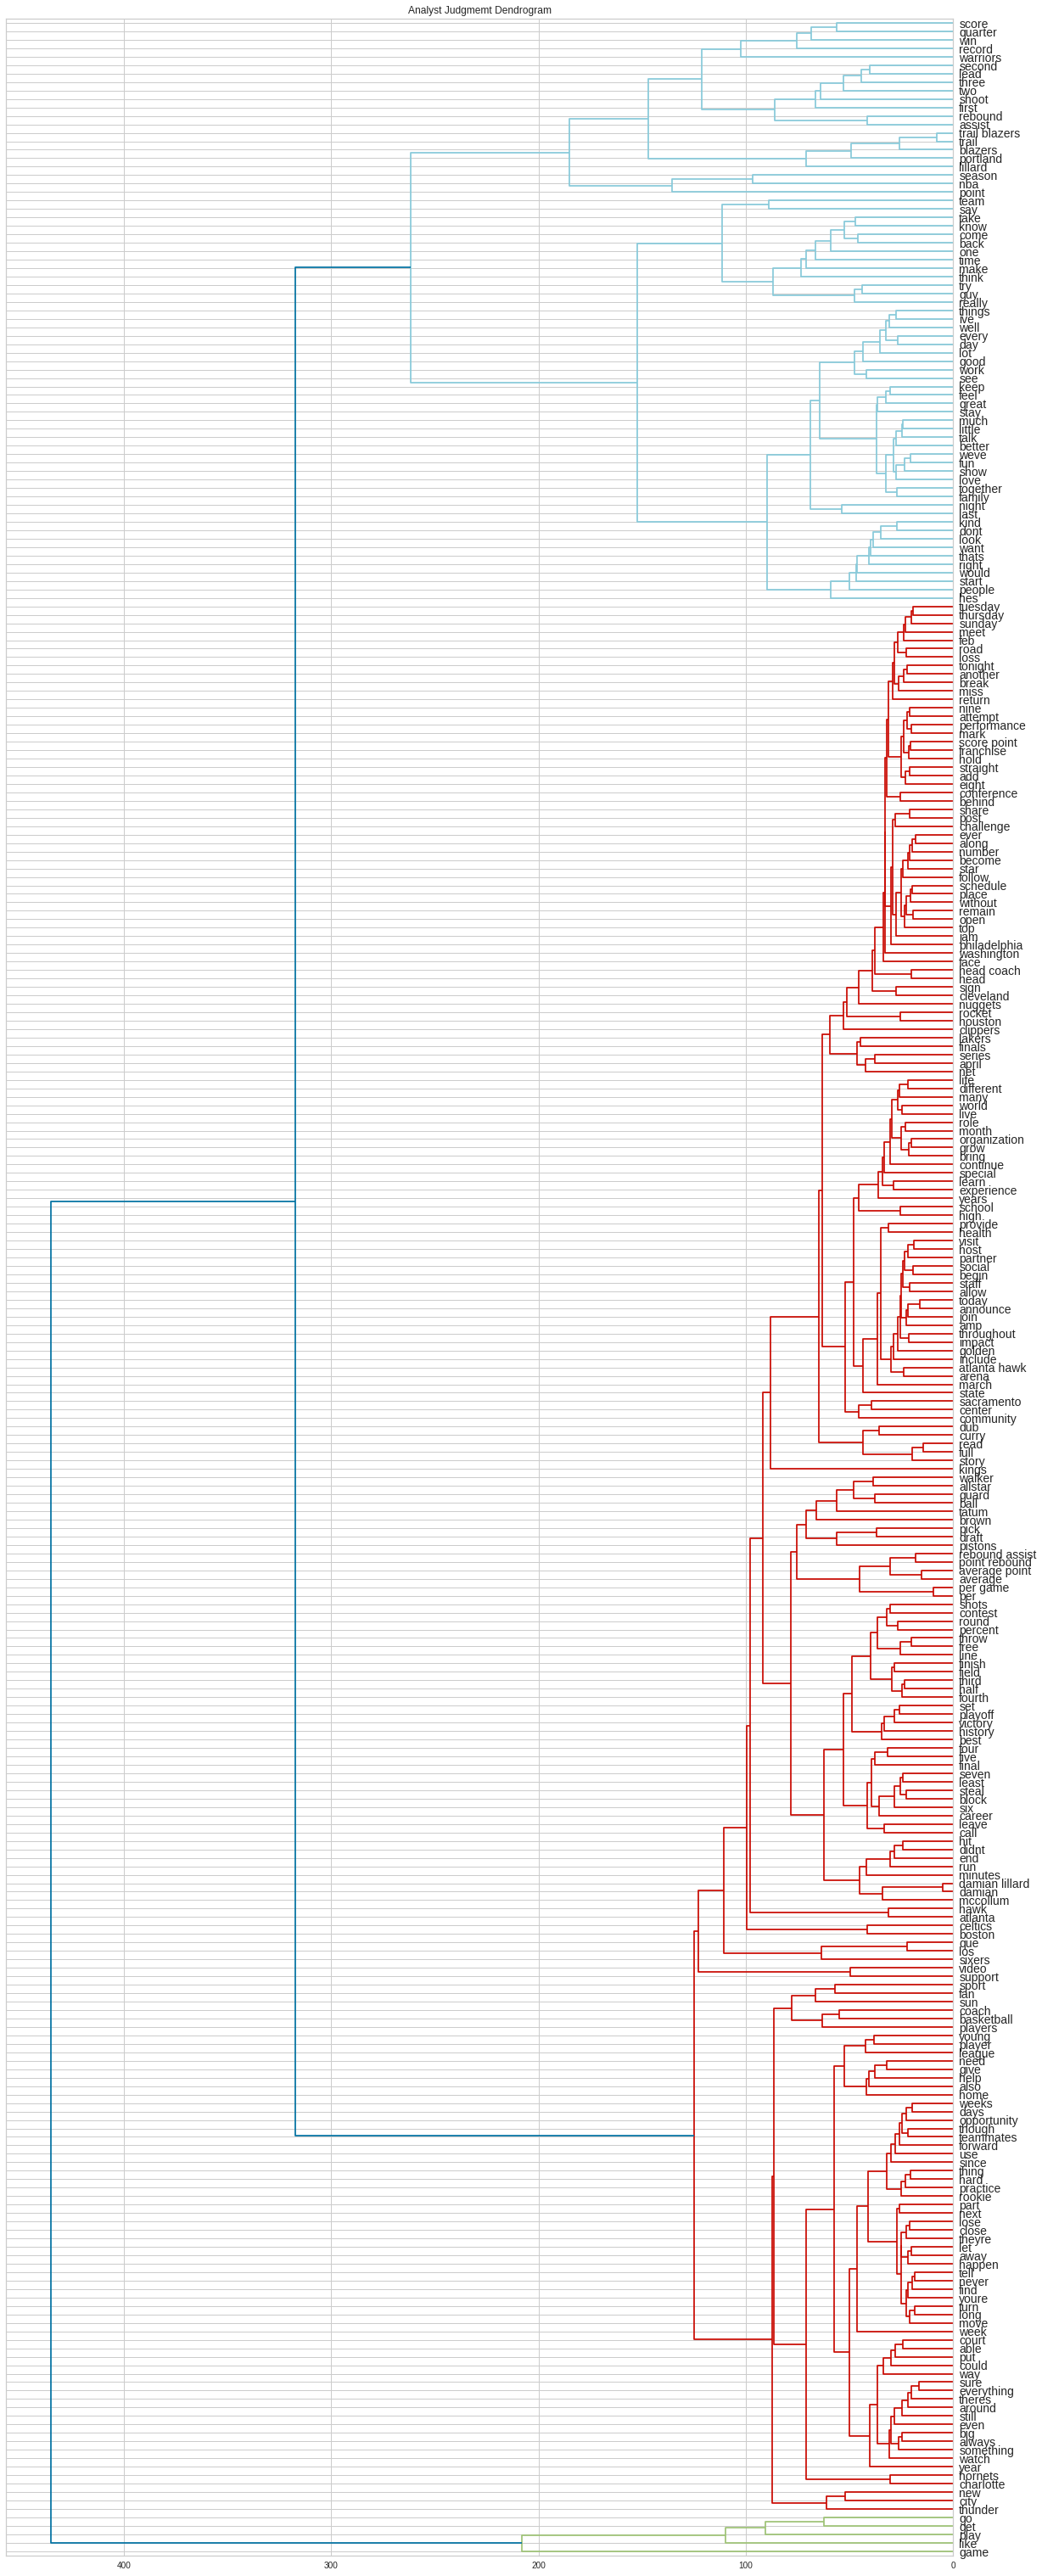

In [0]:
# plot Dendrogram
plt.figure(figsize=(20, 55))
plt.title("Analyst Judgmemt Dendrogram")
dend = dendrogram(
    linkage(analyst_trans.values, method="ward"),
    orientation="left",
    labels=analyst_trans.index,
    leaf_font_size=14
)
plt.savefig("analyst_dendrogram.png")

### Approach 2: TF-IDF

In [0]:
# prepare Dendrogram data
TF_df_trans = TF_df.T

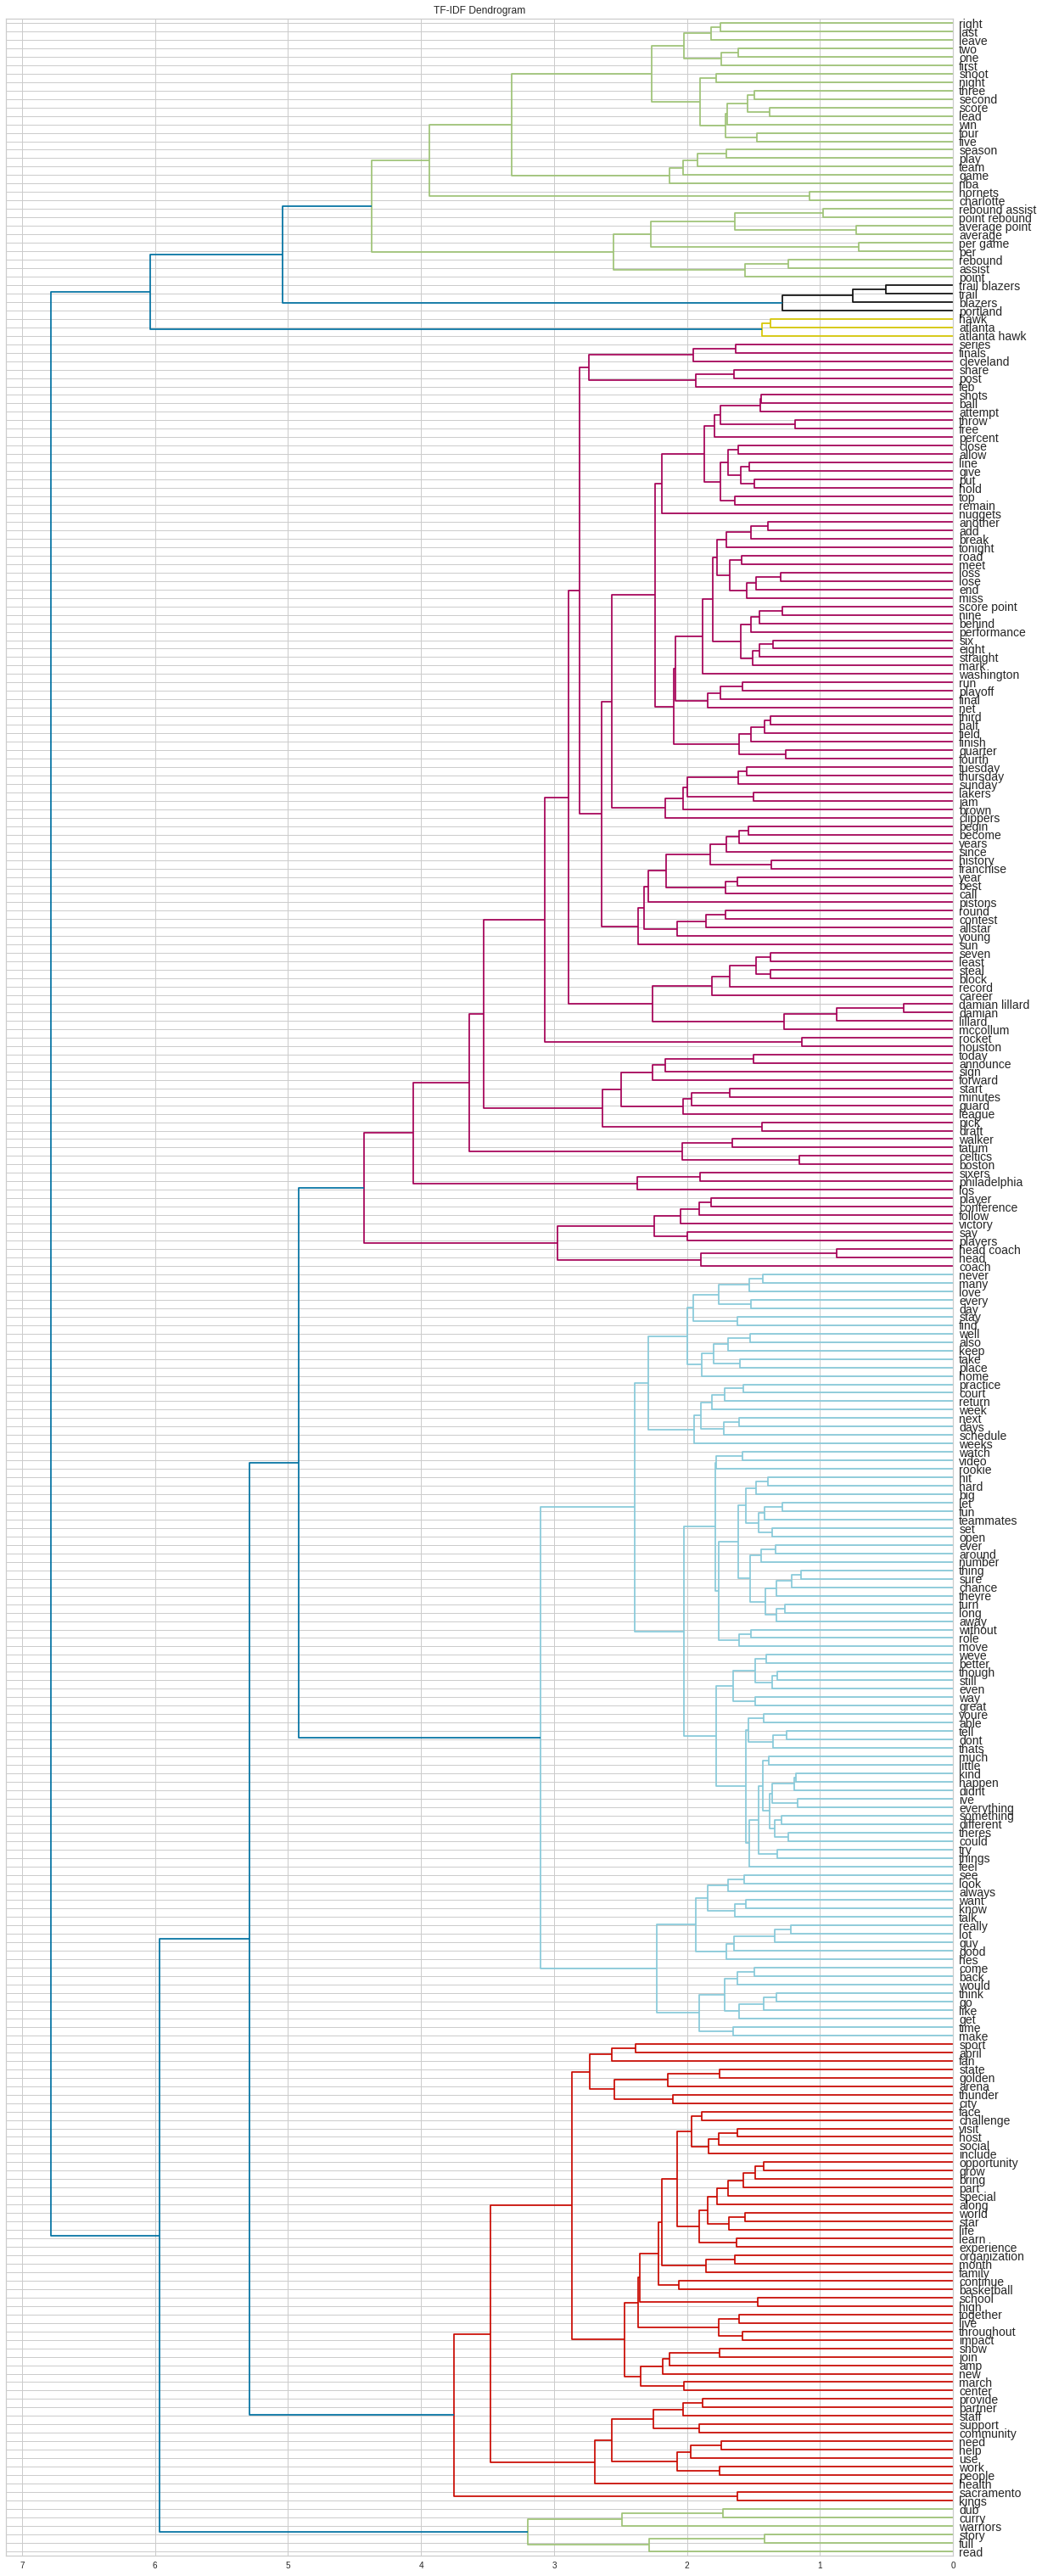

In [0]:
# plot Dendrogram
plt.figure(figsize=(20, 55))
plt.title("TF-IDF Dendrogram")
dend = dendrogram(
    linkage(TF_df_trans.values, method="ward"),
    orientation="left",
    labels=TF_df_trans.index,
    leaf_font_size=14
)
plt.savefig("tfidf_dendrogram.png")

## Activity 7: Compare Hierarchical Clustering and Multidimensional Scaling


## Activity 8: Ontology


# Understanding the Corpus: Topic Modeling and Bi-Clustering

## Activity 9: Topic Modeling

Code was adapted from Selva Prabhakaran's tutorial here:
[Topic Modeling Visualization](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/)

### Load Libraries

In [0]:
import random

import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Prepare Data

In [0]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = news['Text'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['newyork', 'feb', 'hawk', 'guard', 'trae', 'young', 'receive', 'january', 'nba', 'care', 'community', 'assist', 'award', 'present', 'kaiser', 'permanente', 'recognition', 'efforts', 'impact', 'live', 'youth', 'families', 'need', 'georgia', 'oklahoma', 'nba', 'announce', 'todaythe', 'award', 'recognize', 'player', 'month', 'best', 'reflect', 'passion', 'league', 'nba', 'players', 'share', 'give', 'back', 'communities', 'tip', 'young', 'help', 'alleviate', 'financial', 'hardship', 'atlanta', 'families', 'partner', 'rip', 'medical', 'debt', 'relieve', 'insurmountable', 'health', 'expense', 'young', 'donate', 'trae', 'young', 'foundation', 'help', 'eliminate', 'million', 'medical', 'debt', 'nearly', 'individuals', 'throughout', 'atlanta', 'additionally', 'young', 'provide', 'youth', 'native', 'oklahoma', 'place', 'develop', 'skills', 'learn', 'value', 'game', 'trae', 'young', 'basketball', 'academy', 'also', 'help', 'promote', 'education', 'inclusion', 'health', 'wellness', 'across', 'at

### Bigrams & Trigrams

In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# !python3 -m spacy download en  # run in terminal once
# or do
# !conda install -c conda-forge spacy-model-en_core_web_md 
# and use nlp=spacy.load('en_core_web_sm') instead in below function.
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [0]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### Build LDA Model

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.062*"game" + 0.042*"point" + 0.029*"season" + 0.017*"score" + '
  '0.016*"rebound" + 0.016*"first" + 0.016*"last" + 0.015*"win" + 0.014*"lead" '
  '+ 0.013*"team"'),
 (1,
  '0.022*"king" + 0.018*"community" + 0.014*"provide" + 0.013*"support" + '
  '0.012*"help" + 0.010*"create" + 0.009*"team" + 0.009*"local" + 0.009*"work" '
  '+ 0.008*"effort"'),
 (2,
  '0.021*"player" + 0.015*"time" + 0.014*"team" + 0.014*"week" + '
  '0.012*"basketball" + 0.011*"fan" + 0.010*"ingle" + 0.010*"burrell" + '
  '0.009*"life" + 0.009*"first"'),
 (3,
  '0.018*"play" + 0.012*"time" + 0.011*"really" + 0.011*"great" + '
  '0.010*"thing" + 0.010*"look" + 0.010*"back" + 0.010*"feel" + 0.009*"well" + '
  '0.008*"bar"')]


### What is the Dominant topic and its percentage contribution in each document

In [0]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

In [0]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Tokenized_Text']

# put in dataframe
df_dominant_topic = pd.concat([LABELS, IDS, df_dominant_topic, DOCS], axis=1)

df_dominant_topic.head(10)

Relevant  ...                                               Text
0  Irrelevant  ...   newyork feb hawk guard trae young receive jan...
1  Irrelevant  ...   world continue navigate uncertainties around ...
2  Irrelevant  ...   atlanta families senior citizens thomasville ...
3  Irrelevant  ...   espn national basketball association nba nati...
4  Irrelevant  ...   atlanta atlanta hawk hawk foundation state fa...
5    Relevant  ...   atlanta fourth consecutive season atlanta haw...
6  Irrelevant  ...   klchouinard klchouinard youre try gauge serio...
7  Irrelevant  ...   cartersville generate excitement around youth...
8    Relevant  ...   atlanta atlanta hawk sign guard brandon goodw...
9  Irrelevant  ...   atlanta nba allstar weekend conclude atlanta ...

[10 rows x 8 columns]

In [0]:
df_dominant_topic.tail(10)

Relevant  ...                                               Text
741  Irrelevant  ...   tuesday night rui hachimura participate live ...
742  Irrelevant  ...   athletes nutrition plan always take account b...
743  Irrelevant  ...   april autism awareness month joe renae ingles...
744  Irrelevant  ...   thursday wizards tommy sheppard take part liv...
745  Irrelevant  ...   next installment series interview members wiz...
746  Irrelevant  ...   mike conley score three level use either hand...
747  Irrelevant  ...   nba acc acl make way welcome jabariparker pos...
748  Irrelevant  ...   salt lake city mayor erin mendenhalls first t...
749  Irrelevant  ...   utah jazz association atampt sportsnet announ...
750  Irrelevant  ...   ever since actor comedian burrell first visit...

[10 rows x 8 columns]

In [0]:
df_dominant_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Relevant            751 non-null    object 
 1   id                  751 non-null    object 
 2   Document_No         751 non-null    int64  
 3   Dominant_Topic      751 non-null    float64
 4   Topic_Perc_Contrib  751 non-null    float64
 5   Keywords            751 non-null    object 
 6   Tokenized_Text      751 non-null    object 
 7   Text                751 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 47.1+ KB


In [0]:
pd.set_option('display.max_rows',800)
pd.options.display.max_rows

800

In [0]:
df_dominant_topic

Relevant  ...                                               Text
0    Irrelevant  ...   newyork feb hawk guard trae young receive jan...
1    Irrelevant  ...   world continue navigate uncertainties around ...
2    Irrelevant  ...   atlanta families senior citizens thomasville ...
3    Irrelevant  ...   espn national basketball association nba nati...
4    Irrelevant  ...   atlanta atlanta hawk hawk foundation state fa...
5      Relevant  ...   atlanta fourth consecutive season atlanta haw...
6    Irrelevant  ...   klchouinard klchouinard youre try gauge serio...
7    Irrelevant  ...   cartersville generate excitement around youth...
8      Relevant  ...   atlanta atlanta hawk sign guard brandon goodw...
9    Irrelevant  ...   atlanta nba allstar weekend conclude atlanta ...
10     Relevant  ...   atlanta atlanta hawk acquire forwardcenter sk...
11     Relevant  ...   atlanta atlanta hawk acquire point guard derr...
12   Irrelevant  ...   atlanta atlanta hawk amp state farm arena sit...
13     Relevant  ...   atlanta atlanta hawk request waivers forward ...
14   Irrelevant  ...   klchouinard klchouinard trae young busy weeke...
15     Relevant  ...   atlanta atlanta hawk request waivers center n...
16   Irrelevant  ...   atlanta trae young begin allstar weekend win ...
17     Relevant  ...   atlanta atlanta hawk acquire center dewayne d...
18   Irrelevant  ...   atlanta atlanta hawk name latest performer in...
19   Irrelevant  ...   atlanta atlanta hawk secondyear guardtrae you...
20   Irrelevant  ...   atlanta atlanta hawk budweiser team launch te...
21     Relevant  ...   atlanta last night atlanta hawk game versus p...
22     Relevant  ...   atlanta atlanta hawk forward cam reddish leav...
23   Irrelevant  ...   atlanta atlanta hawk release follow statement...
24   Irrelevant  ...   cassidy allen chubb south get something say a...
25     Relevant  ...   atlanta atlanta hawk center alex len leave ja...
26   Irrelevant  ...   new york feb defend champion joe harris brook...
27   Irrelevant  ...   newyork thelos angeles lakers lebron jam lead...
28     Relevant  ...   atlanta hawk guardforward deandre bembry unde...
29   Irrelevant  ...   story chouinard follow twitter klchouinard at...
30   Irrelevant  ...   photo leave right tim whang david elgin andre...
31     Relevant  ...   atlanta atlanta hawk forward jabari parker re...
32   Irrelevant  ...   story chouinard follow twitter klchouinard tr...
33     Relevant  ...   story john collins rock hawk wednesday night ...
34     Relevant  ...   atlanta atlanta hawk acquire guard treveon tr...
35     Relevant  ...   atlanta hawk forward chandler parsons involve...
36     Relevant  ...   atlanta hawk sign paul watson contract announ...
37   Irrelevant  ...   atlanta saturday atlanta hawk state farm unve...
38   Irrelevant  ...   national bank leader become team official ban...
39     Relevant  ...   atlanta atlanta hawk release paul watson anno...
40     Relevant  ...   atlanta hawk forward chandler parsons remain ...
41     Relevant  ...   atlanta atlanta hawk acquire center clint cap...
42     Relevant  ...   atlanta hawk forward jabari parker undergo no...
43   Irrelevant  ...   atlanta atlanta hawk amp state farm arena par...
44   Irrelevant  ...   decatur earlier morning atlanta hawk basketba...
45     Relevant  ...   story chouinard follow twitter klchouinard on...
46   Irrelevant  ...   atlanta today atlanta hawk head coach lloyd p...
47     Relevant  ...   story chouinardtwitter klchouinard brunoferna...
48   Irrelevant  ...   atlanta atlanta hawk point guard trae young l...
49   Irrelevant  ...   atlanta earlier even atlanta hawk basketball ...
50     Relevant  ...   atlanta celebration atlanta hawk forward vinc...
51     Relevant  ...   story trail net early fourth quarter hawk nee...
52     Relevant  ...   atlanta hawksnaismith holiday classic present...
53   Irrelevant  ...   atlantathe atlanta hawk announce plan officia...
54     Relevant  ...   atlanta first time state

### Topic by Relevant

In [0]:
# Group by Clusters
df_dominant_topic['record'] = 1

topic_pivot = pd.pivot_table(df_dominant_topic, values='record', index='Relevant',
                             columns='Dominant_Topic', aggfunc=np.sum)

# 275 total relevant articles
topic_pivot

Dominant_Topic  0.0  1.0  2.0  3.0
Relevant                          
Irrelevant      140  135  119   82
Relevant        192   10   30   43

In [0]:
pd.set_option('display.max_colwidth',1500)

#### Topic 0

In [0]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==0].sort_values(by=['Topic_Perc_Contrib'], ascending = False)

Relevant  ... record
626    Relevant  ...      1
609    Relevant  ...      1
642    Relevant  ...      1
623    Relevant  ...      1
604    Relevant  ...      1
612    Relevant  ...      1
574    Relevant  ...      1
600    Relevant  ...      1
590    Relevant  ...      1
619    Relevant  ...      1
587    Relevant  ...      1
8      Relevant  ...      1
593    Relevant  ...      1
585    Relevant  ...      1
608    Relevant  ...      1
650    Relevant  ...      1
257    Relevant  ...      1
254    Relevant  ...      1
260    Relevant  ...      1
216    Relevant  ...      1
239    Relevant  ...      1
209    Relevant  ...      1
10     Relevant  ...      1
237    Relevant  ...      1
91     Relevant  ...      1
305  Irrelevant  ...      1
491  Irrelevant  ...      1
304  Irrelevant  ...      1
599    Relevant  ...      1
625    Relevant  ...      1
502  Irrelevant  ...      1
617    Relevant  ...      1
610    Relevant  ...      1
694    Relevant  ...      1
270  Irrelevant  ...      1
363  Irrelevant  ...      1
434    Relevant  ...      1
588    Relevant  ...      1
426    Relevant  ...      1
34     Relevant  ...      1
629    Relevant  ...      1
431    Relevant  ...      1
657    Relevant  ...      1
98     Relevant  ...      1
440    Relevant  ...      1
647    Relevant  ...      1
66   Irrelevant  ...      1
448    Relevant  ...      1
631    Relevant  ...      1
667    Relevant  ...      1
321  Irrelevant  ...      1
646    Relevant  ...      1
60   Irrelevant  ...      1
74     Relevant  ...      1
386  Irrelevant  ...      1
407    Relevant  ...      1
398    Relevant  ...      1
630    Relevant  ...      1
11     Relevant  ...      1
191  Irrelevant  ...      1
420  Irrelevant  ...      1
17     Relevant  ...      1
59     Relevant  ...      1
132    Relevant  ...      1
313  Irrelevant  ...      1
318  Irrelevant  ...      1
36     Relevant  ...      1
427    Relevant  ...      1
335  Irrelevant  ...      1
528    Relevant  ...      1
64     Relevant  ...      1
405    Relevant  ...      1
340  Irrelevant  ...      1
404  Irrelevant  ...      1
68     Relevant  ...      1
41     Relevant  ...      1
522    Relevant  ...      1
474    Relevant  ...      1
200    Relevant  ...      1
538    Relevant  ...      1
308  Irrelevant  ...      1
635  Irrelevant  ...      1
96     Relevant  ...      1
190  Irrelevant  ...      1
78     Relevant  ...      1
546    Relevant  ...      1
231    Relevant  ...      1
480  Irrelevant  ...      1
63     Relevant  ...      1
602    Relevant  ...      1
326  Irrelevant  ...      1
428    Relevant  ...      1
547    Relevant  ...      1
560  Irrelevant  ...      1
605    Relevant  ...      1
13     Relevant  ...      1
390  Irrelevant  ...      1
352  Irrelevant  ...      1
598    Relevant  ...      1
303  Irrelevant  ...      1
722  Irrelevant  ...      1
527    Relevant  ...      1
293  Irrelevant  ...      1
207    Relevant  ...      1
525    Relevant  ...      1
329  Irrelevant  ...      1
143    Relevant  ...      1
235    Relevant  ...      1
220    Relevant  ...      1
740  Irrelevant  ...      1
276    Relevant  ...      1
332  Irrelevant  ...      1
116    Relevant  ...      1
358  Irrelevant  ...      1
515    Relevant  ...      1
330  Irrelevant  ...      1
607  Irrelevant  ...      1
264    Relevant  ...      1
94   Irrelevant  ...      1
367  Irrelevant  ...      1
347  Irrelevant  ...      1
19   Irrelevant  ...      1
375  Irrelevant  ...      1
592    Relevant  ...      1
618    Relevant  ...      1
233    Relevant  ...      1
222    Relevant  ...      1
613    Relevant  ...      1
153    Relevant  ...      1
243    Relevant  ...      1
622  Irrelevant  ...      1
155    Relevant  ...      1
210    Relevant  ...      1
221    Relevant  ...      1
639  Irrelevant  ...      1
122    Relevant  ...      1
620  Irrelevant  ...      1
531    Relevant  ...      1
267    Relevant  ...      1
380  Irrelevant  ...      1
212    Relevant  ...      1
181  Irrelevant  ...      1
117

#### Topic 1

In [0]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==1].sort_values(by=['Topic_Perc_Contrib'], ascending = False)

Relevant  ... record
545  Irrelevant  ...      1
565  Irrelevant  ...      1
529  Irrelevant  ...      1
501  Irrelevant  ...      1
306  Irrelevant  ...      1
649  Irrelevant  ...      1
532  Irrelevant  ...      1
2    Irrelevant  ...      1
660  Irrelevant  ...      1
653  Irrelevant  ...      1
483  Irrelevant  ...      1
443  Irrelevant  ...      1
435  Irrelevant  ...      1
30   Irrelevant  ...      1
438  Irrelevant  ...      1
537  Irrelevant  ...      1
664  Irrelevant  ...      1
662  Irrelevant  ...      1
430  Irrelevant  ...      1
511  Irrelevant  ...      1
436  Irrelevant  ...      1
311  Irrelevant  ...      1
573  Irrelevant  ...      1
189  Irrelevant  ...      1
550  Irrelevant  ...      1
685  Irrelevant  ...      1
204  Irrelevant  ...      1
507  Irrelevant  ...      1
423  Irrelevant  ...      1
690  Irrelevant  ...      1
508  Irrelevant  ...      1
73   Irrelevant  ...      1
46   Irrelevant  ...      1
540  Irrelevant  ...      1
99   Irrelevant  ...      1
38   Irrelevant  ...      1
0    Irrelevant  ...      1
391  Irrelevant  ...      1
393  Irrelevant  ...      1
90   Irrelevant  ...      1
505  Irrelevant  ...      1
429  Irrelevant  ...      1
503  Irrelevant  ...      1
414  Irrelevant  ...      1
714  Irrelevant  ...      1
697  Irrelevant  ...      1
701  Irrelevant  ...      1
736  Irrelevant  ...      1
4    Irrelevant  ...      1
445  Irrelevant  ...      1
709  Irrelevant  ...      1
292  Irrelevant  ...      1
689  Irrelevant  ...      1
692  Irrelevant  ...      1
203  Irrelevant  ...      1
695  Irrelevant  ...      1
688  Irrelevant  ...      1
482    Relevant  ...      1
671  Irrelevant  ...      1
577  Irrelevant  ...      1
214  Irrelevant  ...      1
514  Irrelevant  ...      1
97   Irrelevant  ...      1
226  Irrelevant  ...      1
37   Irrelevant  ...      1
645  Irrelevant  ...      1
278  Irrelevant  ...      1
416  Irrelevant  ...      1
700  Irrelevant  ...      1
447    Relevant  ...      1
417  Irrelevant  ...      1
272  Irrelevant  ...      1
683  Irrelevant  ...      1
249  Irrelevant  ...      1
466  Irrelevant  ...      1
44   Irrelevant  ...      1
43   Irrelevant  ...      1
274  Irrelevant  ...      1
70   Irrelevant  ...      1
699  Irrelevant  ...      1
317  Irrelevant  ...      1
9    Irrelevant  ...      1
82   Irrelevant  ...      1
395  Irrelevant  ...      1
403  Irrelevant  ...      1
442  Irrelevant  ...      1
677  Irrelevant  ...      1
495  Irrelevant  ...      1
268  Irrelevant  ...      1
12   Irrelevant  ...      1
513  Irrelevant  ...      1
296  Irrelevant  ...      1
5      Relevant  ...      1
76   Irrelevant  ...      1
301  Irrelevant  ...      1
521  Irrelevant  ...      1
208  Irrelevant  ...      1
67   Irrelevant  ...      1
223  Irrelevant  ...      1
555  Irrelevant  ...      1
581  Irrelevant  ...      1
673  Irrelevant  ...      1
441  Irrelevant  ...      1
437  Irrelevant  ...      1
517  Irrelevant  ...      1
228  Irrelevant  ...      1
749  Irrelevant  ...      1
632    Relevant  ...      1
572  Irrelevant  ...      1
382  Irrelevant  ...      1
406  Irrelevant  ...      1
675  Irrelevant  ...      1
745  Irrelevant  ...      1
691  Irrelevant  ...      1
412  Irrelevant  ...      1
401  Irrelevant  ...      1
399  Irrelevant  ...      1
422  Irrelevant  ...      1
568  Irrelevant  ...      1
718  Irrelevant  ...      1
487  Irrelevant  ...      1
53   Irrelevant  ...      1
504  Irrelevant  ...      1
77   Irrelevant  ...      1
670  Irrelevant  ...      1
3    Irrelevant  ...      1
52     Relevant  ...      1
20   Irrelevant  ...      1
7    Irrelevant  ...      1
111  Irrelevant  ...      1
250  Irrelevant  ...      1
263  Irrelevant  ...      1
21     Relevant  ...      1
18   Irrelevant  ...      1
287  Irrelevant  ...      1
360  Irrelevant  ...      1
327  Irrelevant  ...      1
684    Relevant  ...      1
54     Relevant  ...      1
489    Relevant  ...      1
542    Relevant  ...      1
234  Irrelevant  ...      1
518

#### Topic 2

In [0]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==2].sort_values(by=['Topic_Perc_Contrib'], ascending = False)

Relevant  ... record
55     Relevant  ...      1
31     Relevant  ...      1
42     Relevant  ...      1
389  Irrelevant  ...      1
467  Irrelevant  ...      1
696    Relevant  ...      1
681    Relevant  ...      1
109  Irrelevant  ...      1
579  Irrelevant  ...      1
40     Relevant  ...      1
1    Irrelevant  ...      1
463  Irrelevant  ...      1
728  Irrelevant  ...      1
35     Relevant  ...      1
473    Relevant  ...      1
23   Irrelevant  ...      1
69     Relevant  ...      1
669  Irrelevant  ...      1
366  Irrelevant  ...      1
486    Relevant  ...      1
71     Relevant  ...      1
672  Irrelevant  ...      1
703    Relevant  ...      1
567  Irrelevant  ...      1
400  Irrelevant  ...      1
104  Irrelevant  ...      1
578  Irrelevant  ...      1
388  Irrelevant  ...      1
137    Relevant  ...      1
145    Relevant  ...      1
365  Irrelevant  ...      1
665  Irrelevant  ...      1
499  Irrelevant  ...      1
402  Irrelevant  ...      1
25     Relevant  ...      1
680    Relevant  ...      1
357  Irrelevant  ...      1
108  Irrelevant  ...      1
743  Irrelevant  ...      1
478    Relevant  ...      1
28     Relevant  ...      1
748  Irrelevant  ...      1
584  Irrelevant  ...      1
106  Irrelevant  ...      1
559  Irrelevant  ...      1
678  Irrelevant  ...      1
56     Relevant  ...      1
15     Relevant  ...      1
115    Relevant  ...      1
523  Irrelevant  ...      1
192    Relevant  ...      1
377  Irrelevant  ...      1
750  Irrelevant  ...      1
107  Irrelevant  ...      1
737  Irrelevant  ...      1
719  Irrelevant  ...      1
288  Irrelevant  ...      1
369  Irrelevant  ...      1
381  Irrelevant  ...      1
392  Irrelevant  ...      1
451  Irrelevant  ...      1
589    Relevant  ...      1
160    Relevant  ...      1
123    Relevant  ...      1
723  Irrelevant  ...      1
575  Irrelevant  ...      1
582  Irrelevant  ...      1
371  Irrelevant  ...      1
370  Irrelevant  ...      1
95   Irrelevant  ...      1
285  Irrelevant  ...      1
638  Irrelevant  ...      1
742  Irrelevant  ...      1
289  Irrelevant  ...      1
364  Irrelevant  ...      1
464  Irrelevant  ...      1
556  Irrelevant  ...      1
314  Irrelevant  ...      1
161    Relevant  ...      1
170    Relevant  ...      1
49   Irrelevant  ...      1
735  Irrelevant  ...      1
548  Irrelevant  ...      1
586  Irrelevant  ...      1
343  Irrelevant  ...      1
457  Irrelevant  ...      1
570  Irrelevant  ...      1
387  Irrelevant  ...      1
563  Irrelevant  ...      1
674    Relevant  ...      1
323  Irrelevant  ...      1
720  Irrelevant  ...      1
668  Irrelevant  ...      1
309  Irrelevant  ...      1
424  Irrelevant  ...      1
452  Irrelevant  ...      1
325  Irrelevant  ...      1
446  Irrelevant  ...      1
103  Irrelevant  ...      1
744  Irrelevant  ...      1
571  Irrelevant  ...      1
553  Irrelevant  ...      1
376  Irrelevant  ...      1
433  Irrelevant  ...      1
397  Irrelevant  ...      1
374  Irrelevant  ...      1
334  Irrelevant  ...      1
603  Irrelevant  ...      1
569  Irrelevant  ...      1
705  Irrelevant  ...      1
564  Irrelevant  ...      1
29   Irrelevant  ...      1
322  Irrelevant  ...      1
470  Irrelevant  ...      1
312  Irrelevant  ...      1
506  Irrelevant  ...      1
663  Irrelevant  ...      1
627    Relevant  ...      1
658    Relevant  ...      1
373  Irrelevant  ...      1
476  Irrelevant  ...      1
384  Irrelevant  ...      1
655  Irrelevant  ...      1
286  Irrelevant  ...      1
512  Irrelevant  ...      1
490  Irrelevant  ...      1
461  Irrelevant  ...      1
349  Irrelevant  ...      1
698  Irrelevant  ...      1
368  Irrelevant  ...      1
24   Irrelevant  ...      1
105  Irrelevant  ...      1
193  Irrelevant  ...      1
159  Irrelevant  ...      1
682  Irrelevant  ...      1
333  Irrelevant  ...      1
291  Irrelevant  ...      1
472  Irrelevant  ...      1
337  Irrelevant  ...      1
562  Irrelevant  ...      1
324  Irrelevant  ...      1
693  Irrelevant  ...      1
277

#### Topic 3

In [0]:
df_dominant_topic[df_dominant_topic['Dominant_Topic']==3].sort_values(by=['Topic_Perc_Contrib'], ascending = False)

Relevant  ... record
460  Irrelevant  ...      1
747  Irrelevant  ...      1
724  Irrelevant  ...      1
173    Relevant  ...      1
179    Relevant  ...      1
469  Irrelevant  ...      1
485  Irrelevant  ...      1
130    Relevant  ...      1
202    Relevant  ...      1
477    Relevant  ...      1
275  Irrelevant  ...      1
488  Irrelevant  ...      1
199    Relevant  ...      1
552  Irrelevant  ...      1
147    Relevant  ...      1
139    Relevant  ...      1
661  Irrelevant  ...      1
188    Relevant  ...      1
178    Relevant  ...      1
725  Irrelevant  ...      1
138    Relevant  ...      1
128    Relevant  ...      1
419  Irrelevant  ...      1
462  Irrelevant  ...      1
187    Relevant  ...      1
251    Relevant  ...      1
741  Irrelevant  ...      1
450  Irrelevant  ...      1
185  Irrelevant  ...      1
14   Irrelevant  ...      1
496  Irrelevant  ...      1
126    Relevant  ...      1
408  Irrelevant  ...      1
594    Relevant  ...      1
727  Irrelevant  ...      1
271  Irrelevant  ...      1
299  Irrelevant  ...      1
172  Irrelevant  ...      1
494  Irrelevant  ...      1
157  Irrelevant  ...      1
497  Irrelevant  ...      1
265  Irrelevant  ...      1
80     Relevant  ...      1
729  Irrelevant  ...      1
174    Relevant  ...      1
656  Irrelevant  ...      1
561    Relevant  ...      1
51     Relevant  ...      1
124    Relevant  ...      1
45     Relevant  ...      1
183  Irrelevant  ...      1
409  Irrelevant  ...      1
615  Irrelevant  ...      1
186  Irrelevant  ...      1
471  Irrelevant  ...      1
558  Irrelevant  ...      1
84   Irrelevant  ...      1
734  Irrelevant  ...      1
114    Relevant  ...      1
576  Irrelevant  ...      1
492    Relevant  ...      1
156    Relevant  ...      1
410  Irrelevant  ...      1
628    Relevant  ...      1
500  Irrelevant  ...      1
484  Irrelevant  ...      1
57   Irrelevant  ...      1
738  Irrelevant  ...      1
79     Relevant  ...      1
118    Relevant  ...      1
32   Irrelevant  ...      1
539    Relevant  ...      1
152  Irrelevant  ...      1
163  Irrelevant  ...      1
232  Irrelevant  ...      1
205    Relevant  ...      1
151    Relevant  ...      1
262  Irrelevant  ...      1
47     Relevant  ...      1
449  Irrelevant  ...      1
644  Irrelevant  ...      1
219  Irrelevant  ...      1
596    Relevant  ...      1
535    Relevant  ...      1
146    Relevant  ...      1
131    Relevant  ...      1
659    Relevant  ...      1
253  Irrelevant  ...      1
498  Irrelevant  ...      1
133    Relevant  ...      1
6    Irrelevant  ...      1
319  Irrelevant  ...      1
554  Irrelevant  ...      1
425  Irrelevant  ...      1
686    Relevant  ...      1
165  Irrelevant  ...      1
300  Irrelevant  ...      1
298  Irrelevant  ...      1
717  Irrelevant  ...      1
710  Irrelevant  ...      1
171    Relevant  ...      1
166    Relevant  ...      1
310  Irrelevant  ...      1
89   Irrelevant  ...      1
541  Irrelevant  ...      1
58     Relevant  ...      1
169  Irrelevant  ...      1
198  Irrelevant  ...      1
731  Irrelevant  ...      1
320  Irrelevant  ...      1
290  Irrelevant  ...      1
704  Irrelevant  ...      1
225  Irrelevant  ...      1
707  Irrelevant  ...      1
648  Irrelevant  ...      1
456  Irrelevant  ...      1
164    Relevant  ...      1
733  Irrelevant  ...      1
481  Irrelevant  ...      1
197  Irrelevant  ...      1
415  Irrelevant  ...      1
378  Irrelevant  ...      1
687  Irrelevant  ...      1
739  Irrelevant  ...      1
465  Irrelevant  ...      1

[125 rows x 9 columns]

### The most representative sentence for each topic

In [0]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  ...                                                                                  Representative Text
0        0.0  ...  [secure, comefrombehind, victory, night, board, plane, face, jazz, second, game, backtoback, tip...
1        1.0  ...  [para, ello, increble, philly, nuevo, ventaja, poco, desde, ltimo, periodo, estar, pero, reaccin...
2        2.0  ...  [undergo, medical, examination, assessment, mri, today, diagnose, associate, shoulder, capsule, ...
3        3.0  ...                                                 [forward, welcome, draft, cesar, pass, word, wisdom]

[4 rows x 4 columns]

In [0]:
sent_topics_sorteddf_mallet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Topic_Num            4 non-null      float64
 1   Topic_Perc_Contrib   4 non-null      float64
 2   Keywords             4 non-null      object 
 3   Representative Text  4 non-null      object 
dtypes: float64(2), object(2)
memory usage: 256.0+ bytes


### Frequency Distribution of Word Counts in Documents

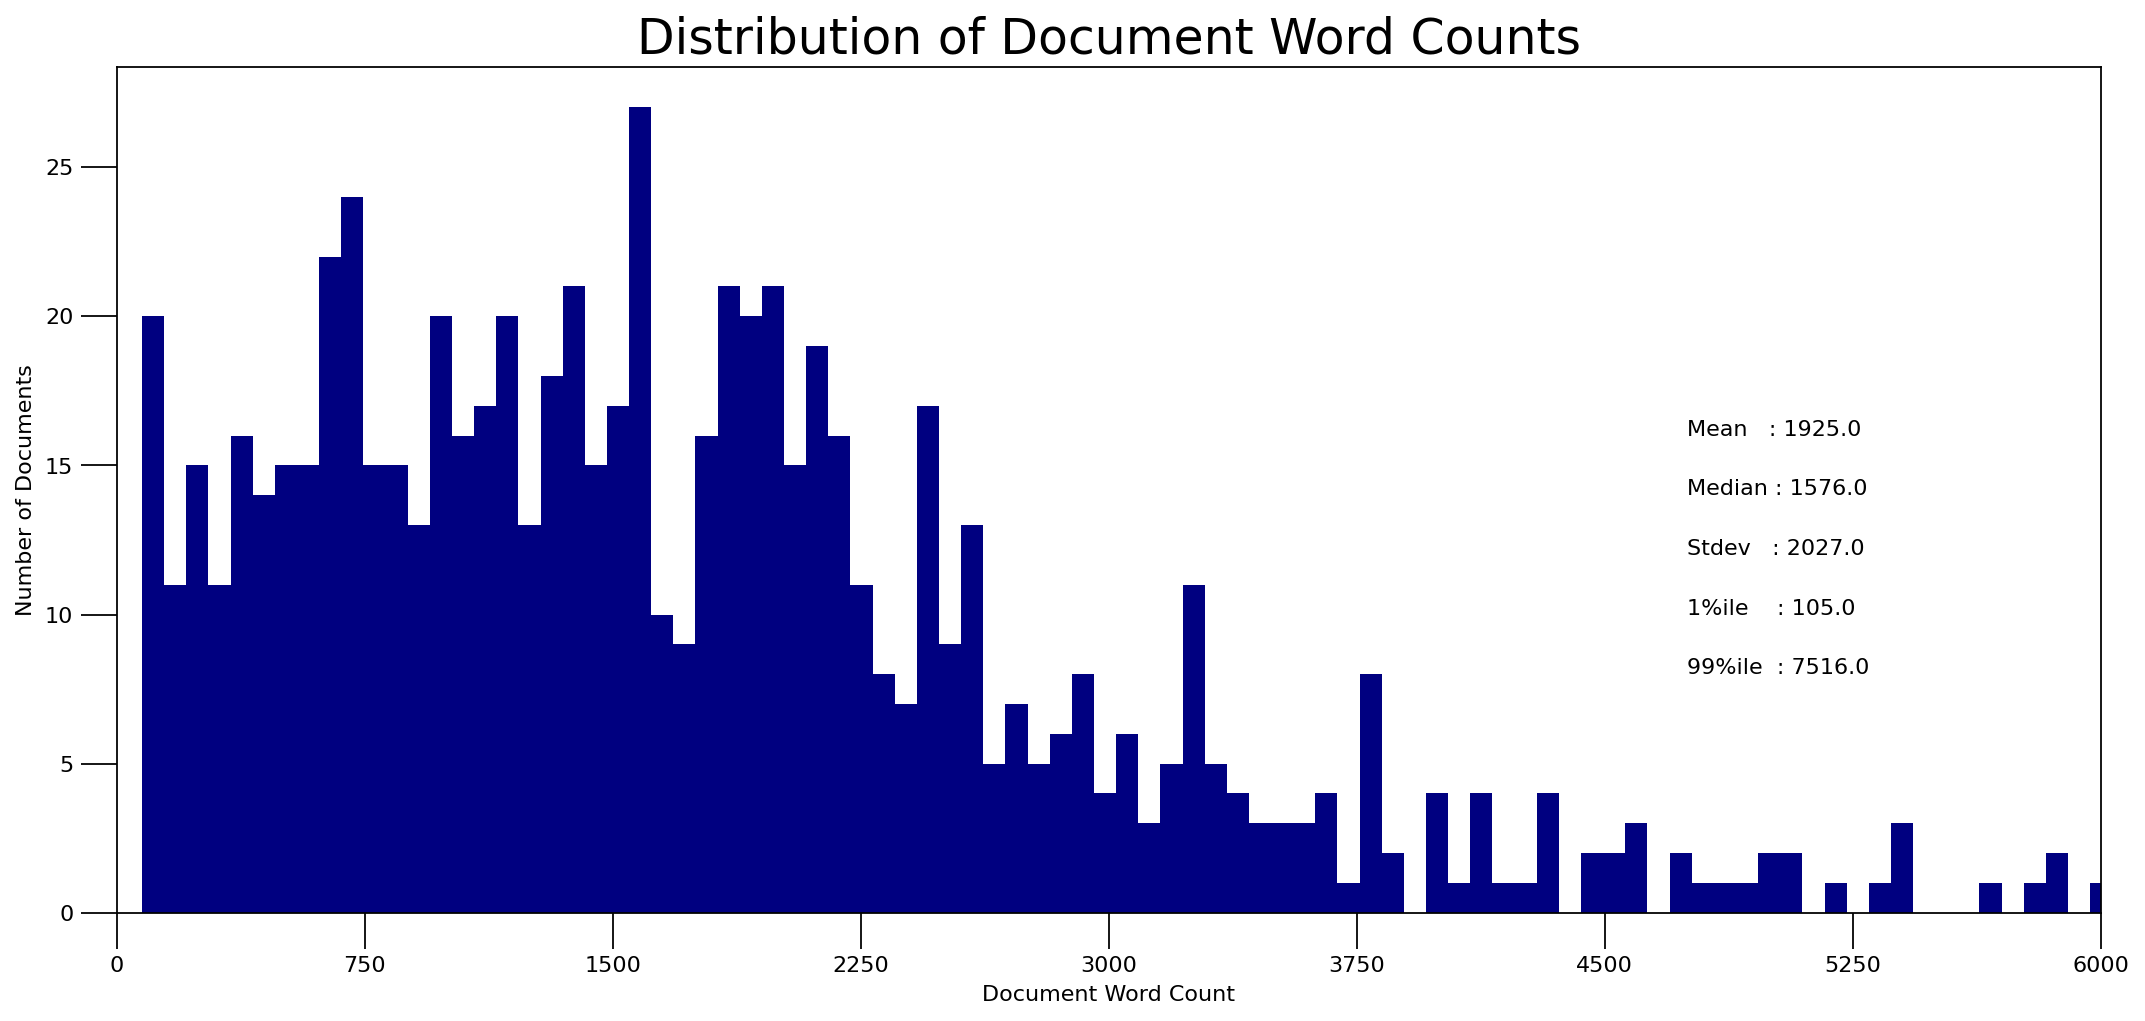

In [0]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(4750,  16, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(4750,  14, "Median : " + str(round(np.median(doc_lens))))
plt.text(4750,  12, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(4750,  10, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(4750,  8, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 6000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,6000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

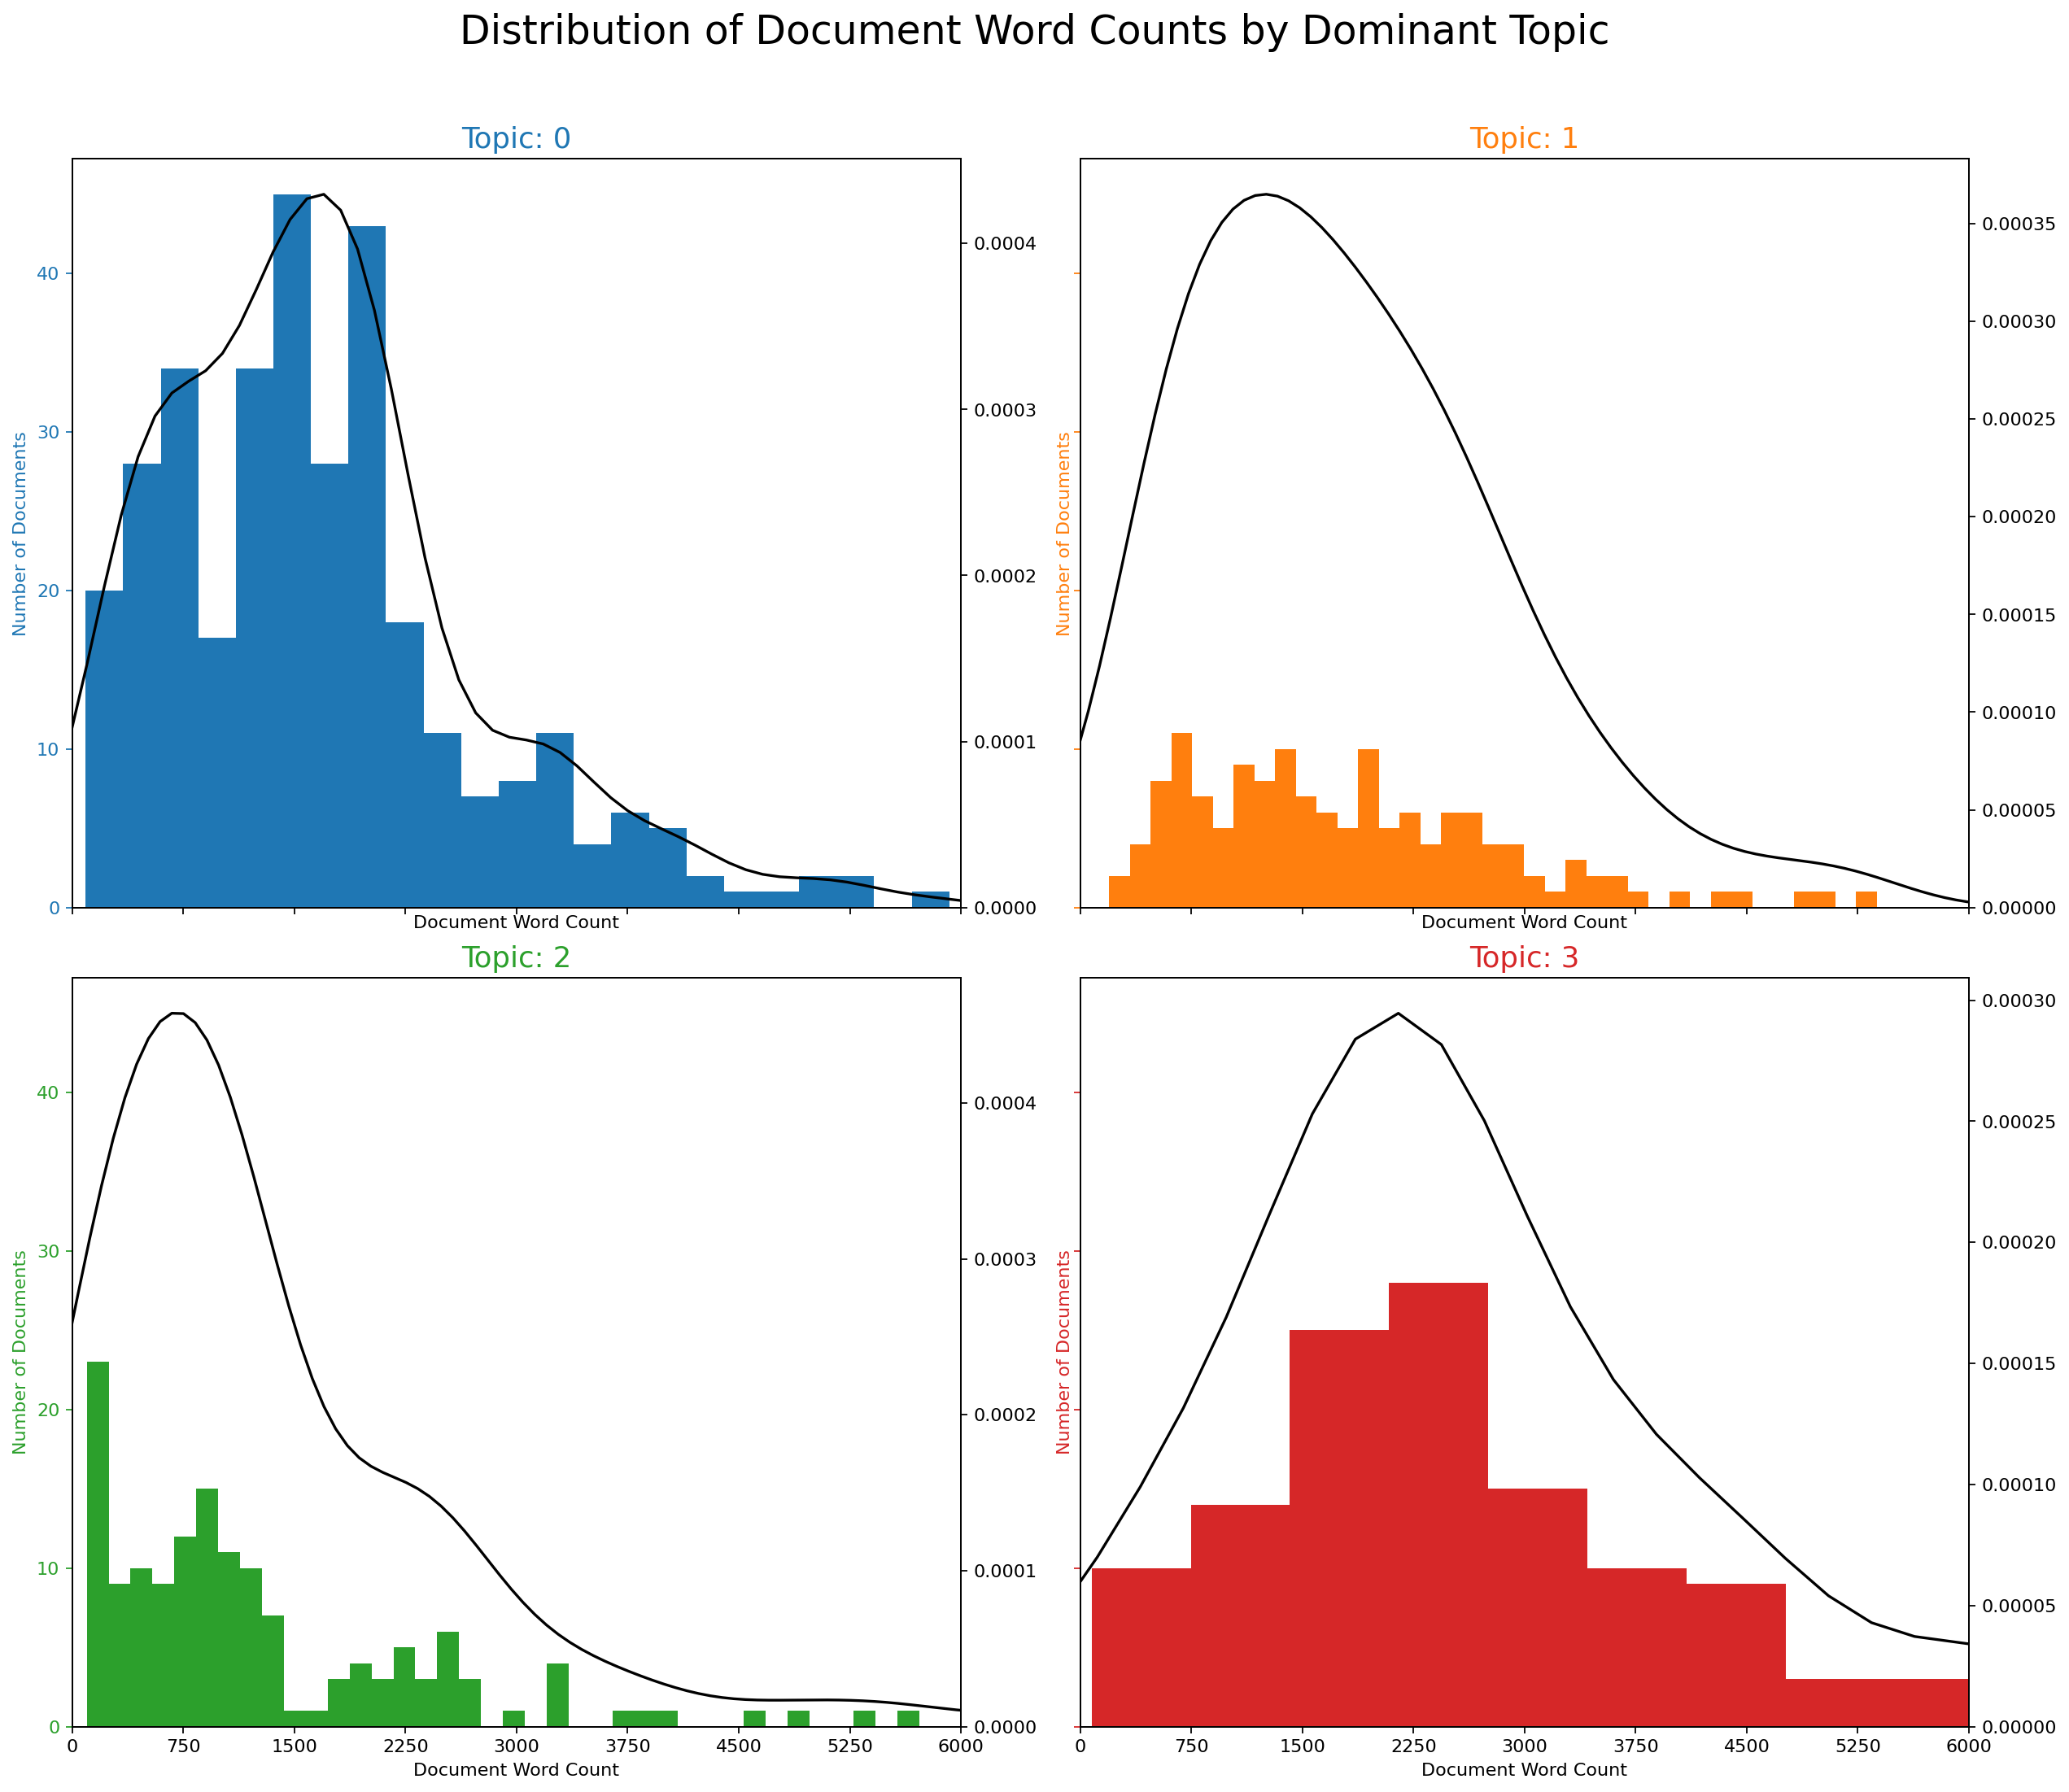

In [0]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 50, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 6000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,6000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

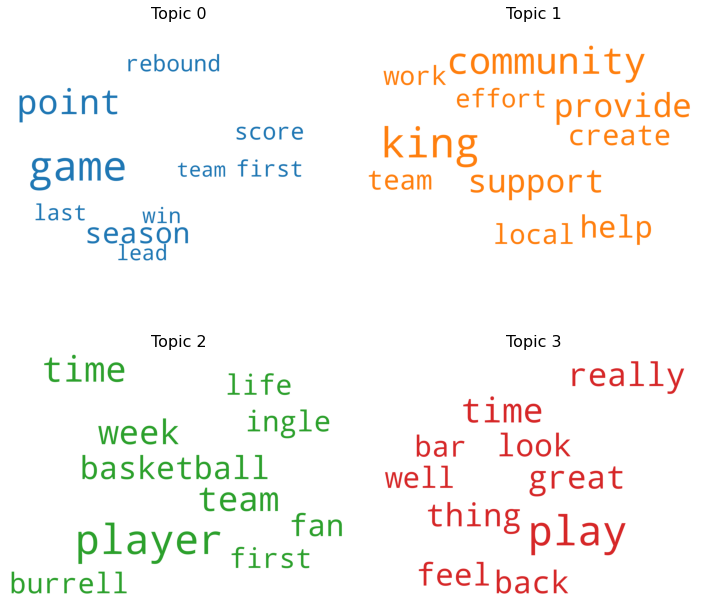

In [0]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

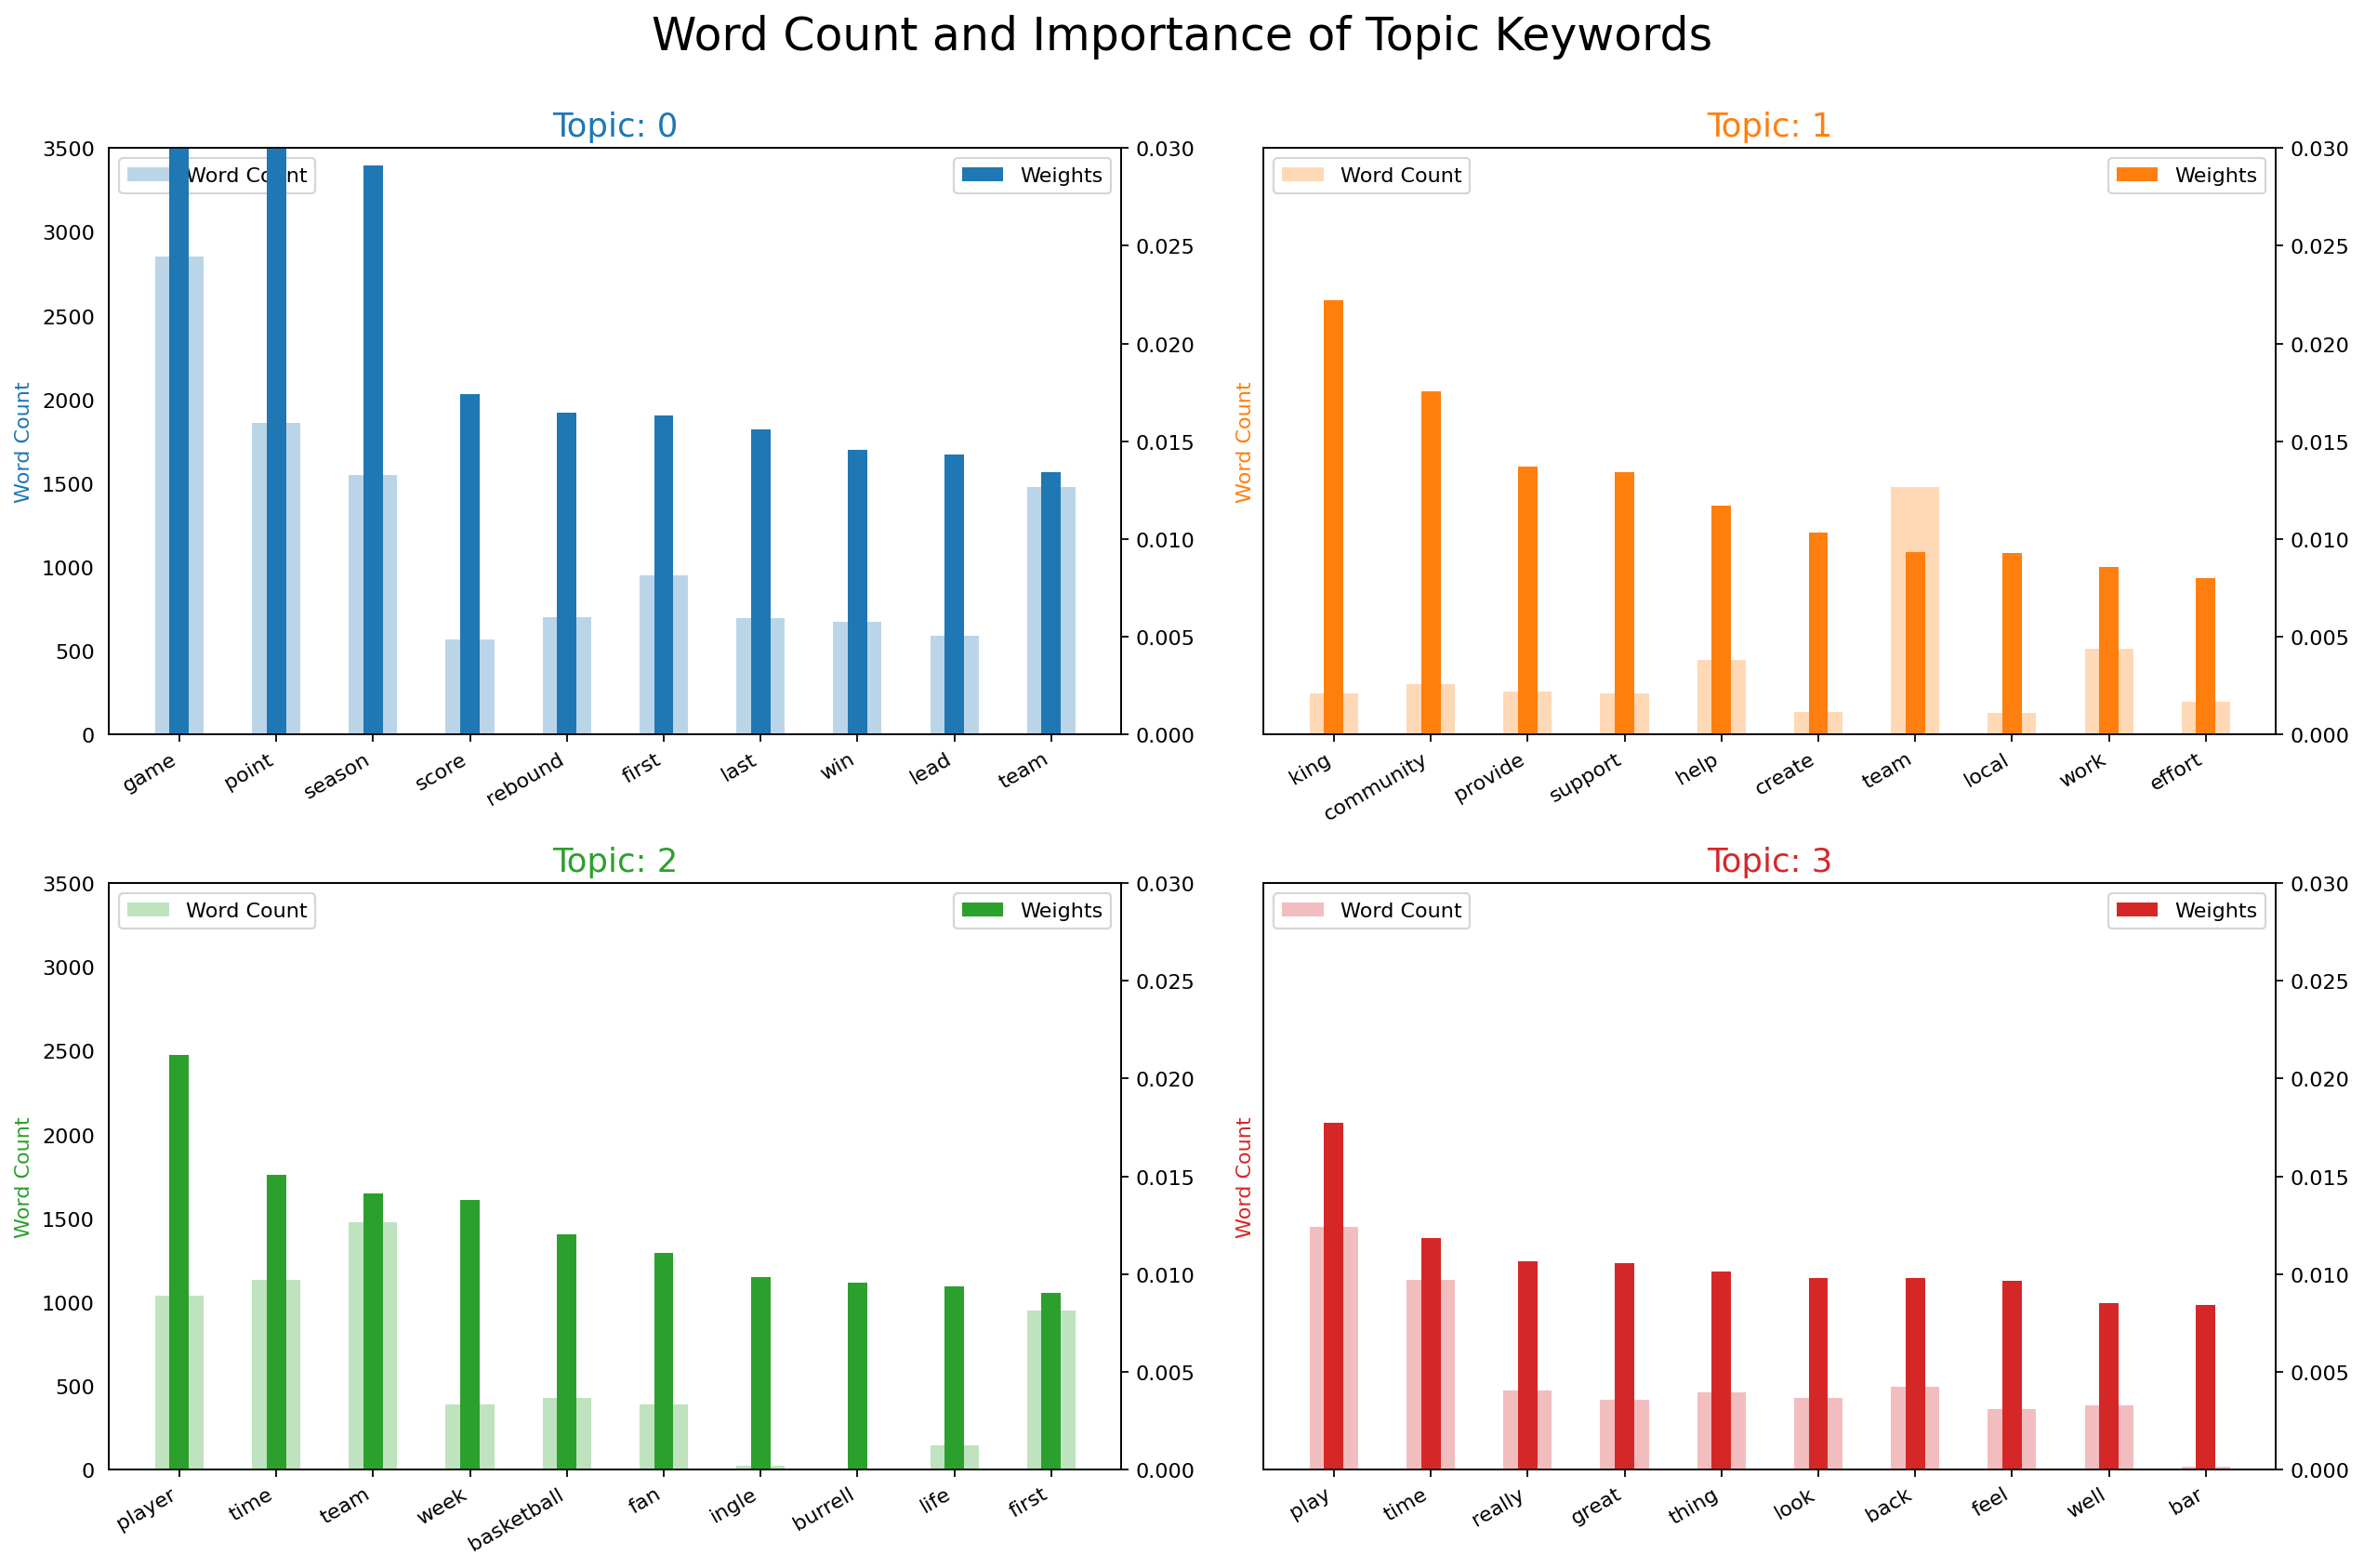

In [0]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Sentence Chart Colored by Topic

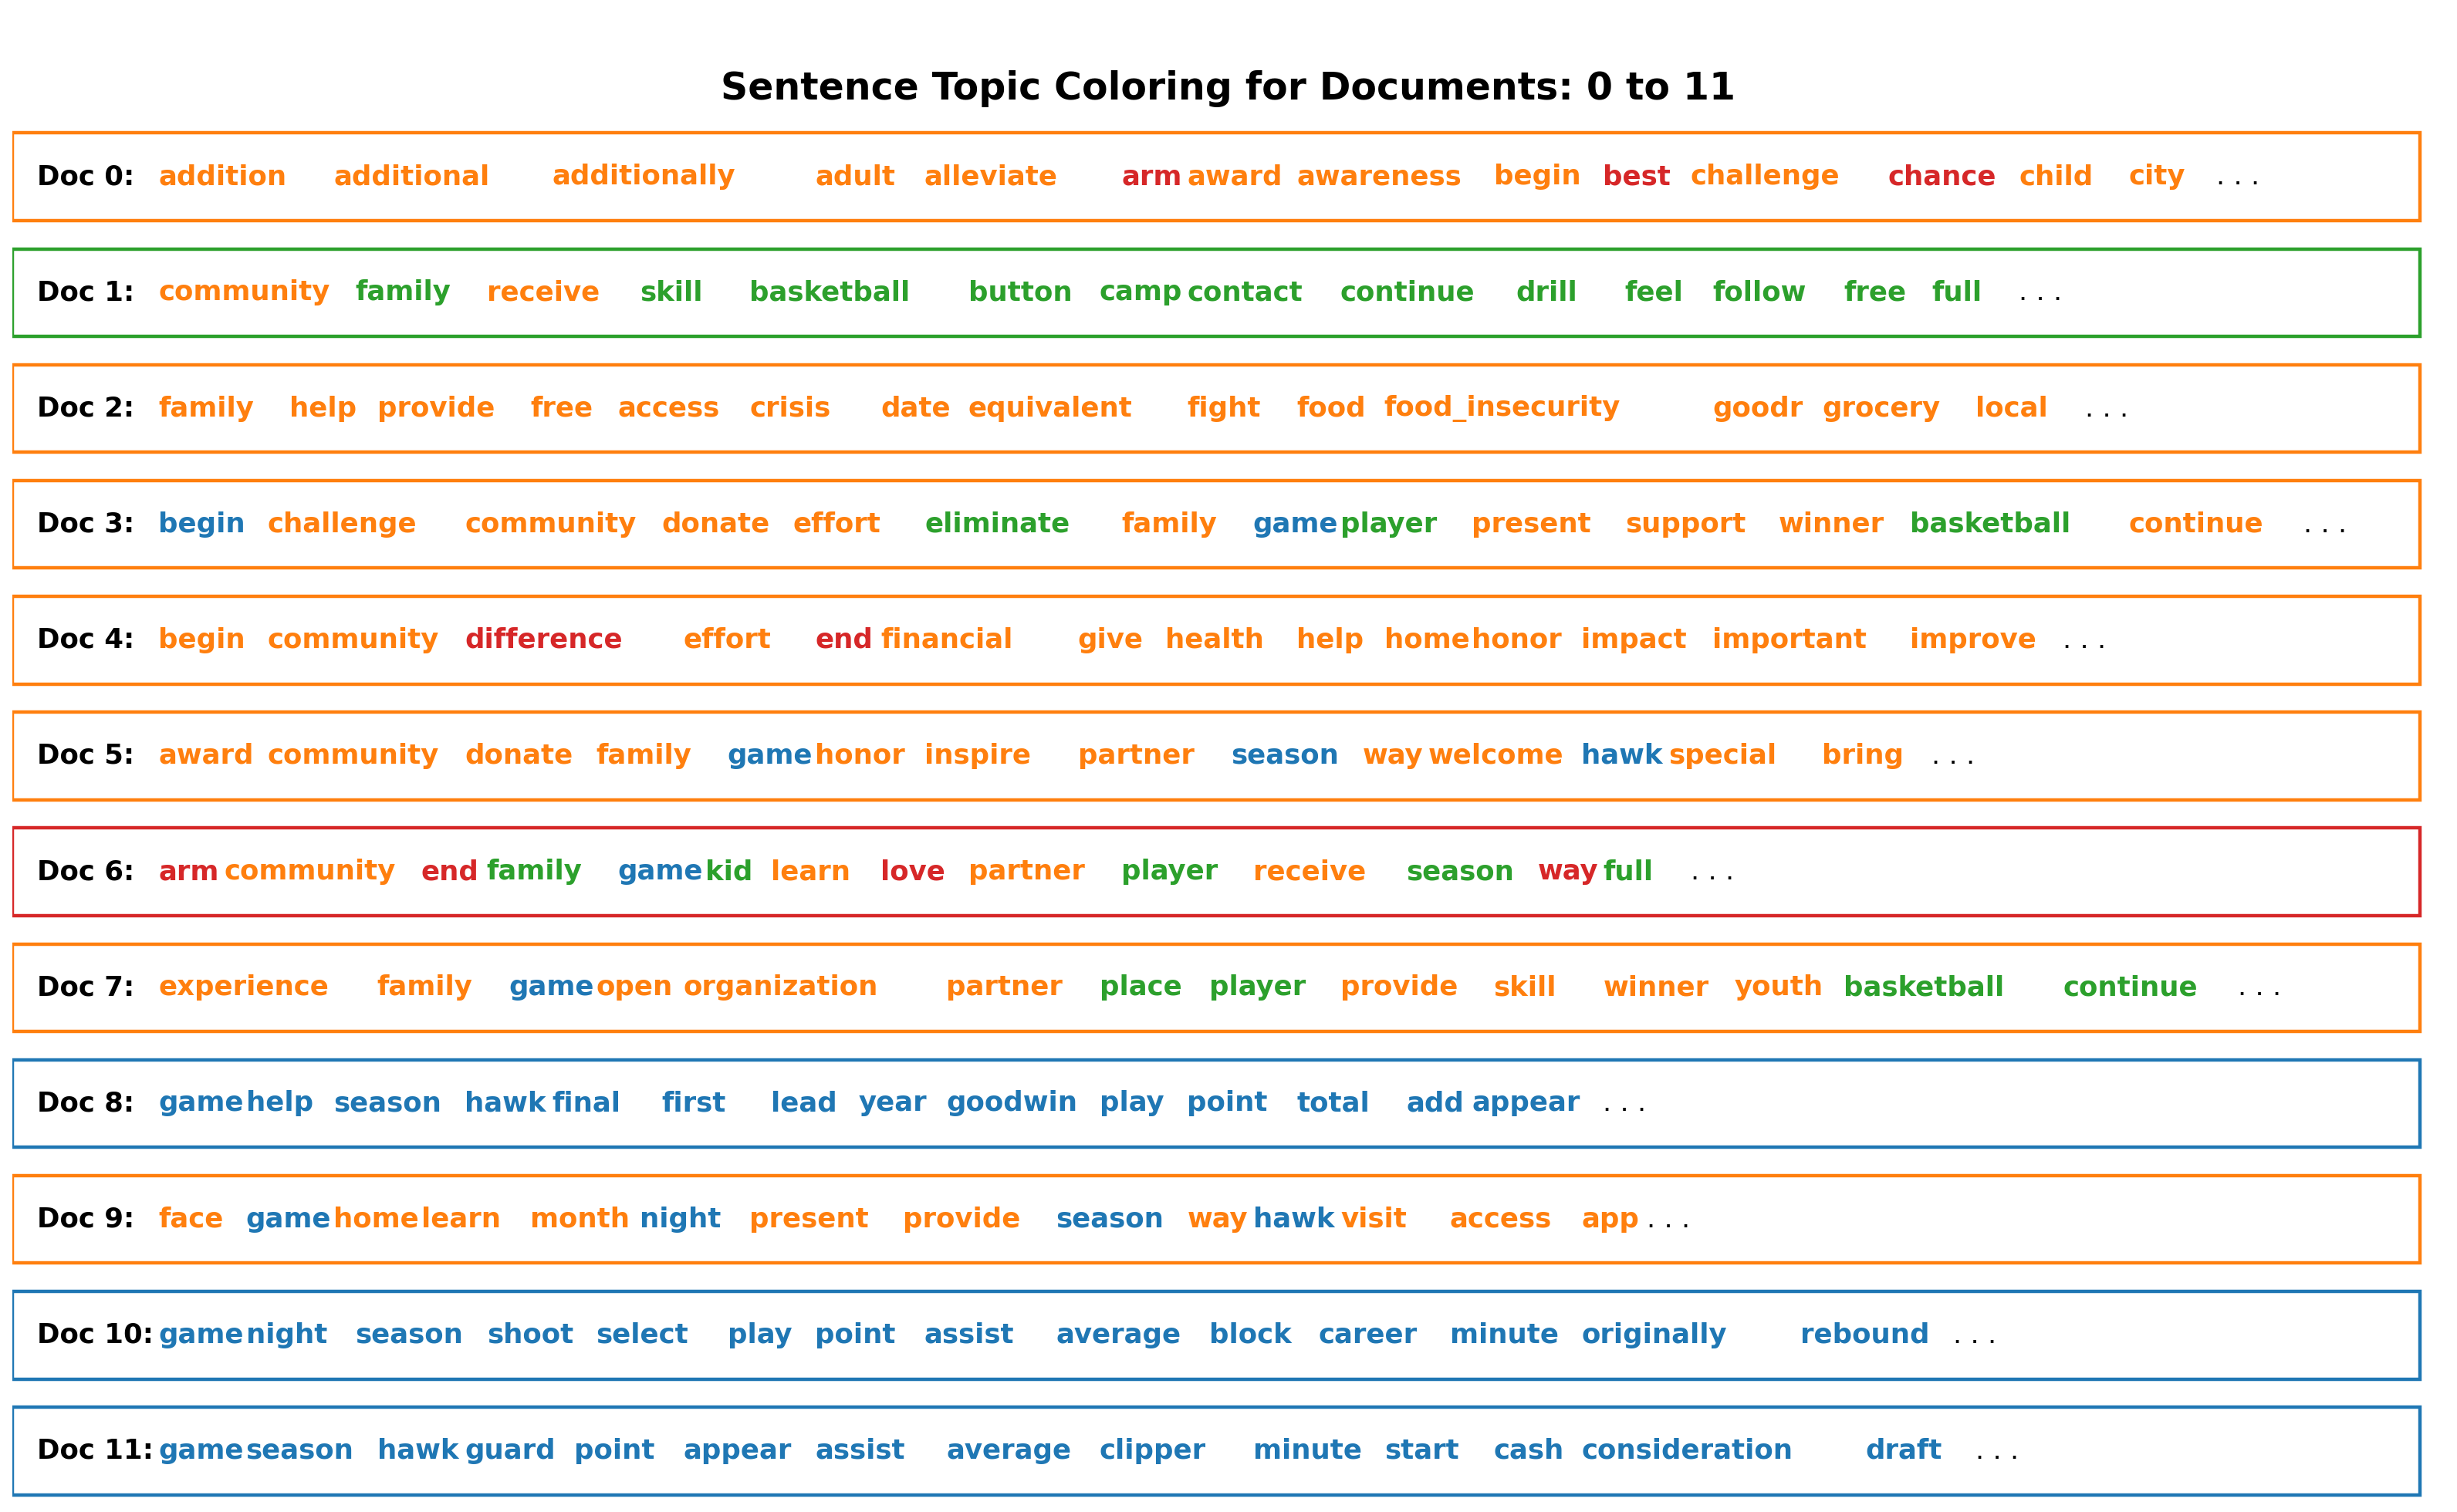

In [0]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

### Most Discussed Topics in Articles

In [0]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

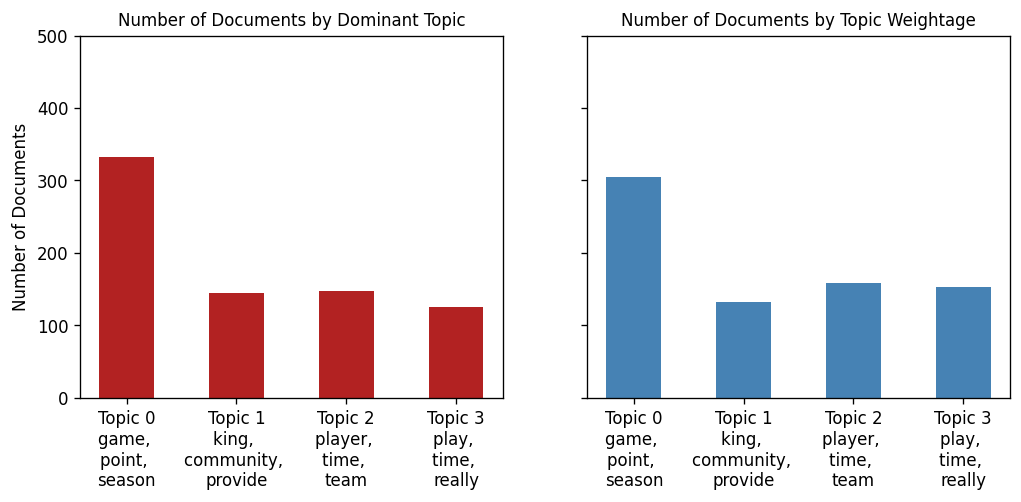

In [0]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 500)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

### t-SNE Clustering Chart

In [0]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 738 samples in 0.001s...
[t-SNE] Computed neighbors for 738 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 738 / 738
[t-SNE] Mean sigma: 0.050299
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.687172
[t-SNE] KL divergence after 1000 iterations: 0.409691


### pyLDAVis

In [0]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 8.4MB/s 
     |████████████████████████████████| 552kB 44.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=1390e540fad1ad7f35c20215b6b8e848912a2f232433327a2dc17ec99c12f992
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=af2979d9e9f72955a864cbbf73db3ae3ec8e48c9f710c7d4569289b104e696a1
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.246467 -0.170018       1        1  36.007290
3     -0.090638  0.198962       2        1  29.243082
2      0.091077  0.108094       3        1  18.873716
1      0.246028 -0.137038       4        1  15.875904, topic_info=            Term         Freq        Total Category  logprob  loglift
514        point  1774.000000  1774.000000  Default  30.0000  30.0000
31          game  2894.000000  2894.000000  Default  29.0000  29.0000
76        season  1439.000000  1439.000000  Default  28.0000  28.0000
179        score   742.000000   742.000000  Default  27.0000  27.0000
698         king   550.000000   550.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
193     together   102.578804   184.628906   Topic4  -5.2107   1.2527
330         team   175.003510  1255.428955   Topic4  -4.6765  -0.1301
631         last   114.795830   780.605530   Topic4  -5.0982  -0.0765
282  opportunity    93.989464   201.764938   Topic4  -5.2982   1.0764
27    experience    93.056992   223.063828   Topic4  -5.3081   0.9661

[244 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
195       2  0.928144     able
195       3  0.069902     able
617       1  0.997432      add
5182      3  0.974973    adopt
1173      2  0.990613   almost
...     ...       ...      ...
1359      3  0.987553  workout
437       1  0.229769     year
437       2  0.485307     year
437       3  0.216885     year
437       4  0.066569     year

[325 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2])

## Activity 10: Bi-Clustering
